Notes:

- Email Marketing.
- Digital Marketing Strategy.
- Marketers spend lot of time in writing perfect emails, perfecting every word and layouts on multiple devices, this all is done to increase open and click rates.
- How can I build my campaign to increase click-through rates of email ?


Problem Statement

```
Analytics Vidhya sends out marketing emailers for various events such as conferences, hackathons, etc. We have provided a sample of user-email interaction data from July 2017 to December 2017. You are required to predict the click probability of links inside a mailer for email campaigns from January 2018 to March 2018.
```

Dataset Description

`Campaings Data`


Contains the features related to 52 email Campaigns

- campaign_id          : Campaign ID
- communication_type   : Email Agenda
- total_links          : Total links inside the email
- no_of_internal_links : Total internal links inside the email (redirecting to analyticsvidhya.com)
- no_of_images         : Number of images inside the email
- no_of_sections       : Number of sections inside the email
- email_body           : Email Text
- subject              : Email Subject
- email_url            : Email URL

`Train Data`

Contains the click and open information for each user corresponding to given campaign id (Jul 17 - Dec 17)

- id          : Unique id of email session
- user_id     : UserID
- campaign_id : Email Campaign ID
- send_date   : Time stamp for email sent
- is_open     : Did not open - 0, Opened -1
- is_click    : Did not click - 0, clicked - 1

`Test Data`

Contains the user and campaigns for which is_click needs to be predicted (Jan 18 - Mar 18)

- id          : Unique ID for email session
- campaign_id : Email Campaign ID
- user_id     : UserID
- send_date   : Timestamp of email sent.

** Evaluation Metric: ROC-AUC Score **

** PUBLIC AND PRIVATE SPLIT **

Note that the test data is further __randomly__ divided into Public (30%) and Private (70%) data. Your initial responses will be checked and scored on the Public data.

The final rankings would be based on your private score which will be published once the competition is over.

** Rules **

- Use of external dataset and id variables is not allowed for creating model 
  ** (campaign_id and user_id cannot be directly used as a feature) **

In [11]:
!head -n 19 ../data/raw/campaign_data.csv

In [5]:
!tail ../data/raw/train.csv

In [9]:
!head ../data/raw/test.csv

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


# Load Additional Libraries

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.externals import joblib

import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

# PATHS

In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')
TRAIN_PATH     = os.path.join(basepath, 'data/raw/train.csv')
TEST_PATH      = os.path.join(basepath, 'data/raw/test.csv')

# Load Data

In [ ]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_csv(f'{TRAIN_PATH}', dayfirst=True, parse_dates=['send_date'])
test      = pd.read_csv(f'{TEST_PATH}', dayfirst=True, parse_dates=['send_date'])

# Preprocessing

In [ ]:
%%time

train_info = train.merge(campaigns[['campaign_id', 'subject', 'communication_type', 'total_links',
       'no_of_internal_links', 'no_of_images', 'no_of_sections']], on='campaign_id', how='left')
test_info  = test.merge(campaigns[['campaign_id', 'subject', 'communication_type', 'total_links',
       'no_of_internal_links', 'no_of_images', 'no_of_sections']], on='campaign_id', how='left')

In [7]:
%%time

train_info.to_feather('../data/processed/train_textv1.feather')
test_info.to_feather('../data/processed/test_textv1.feather')

CPU times: user 3.51 s, sys: 1.94 s, total: 5.45 s
Wall time: 22.2 s


# Load Processed Data

In [3]:
%%time

train_info = pd.read_feather('../data/processed/train_text.feather')
test_info  = pd.read_feather('../data/processed/test_text.feather')

CPU times: user 632 ms, sys: 331 ms, total: 963 ms
Wall time: 4.32 s


In [4]:
train_info.columns

Index(['id', 'user_id', 'campaign_id', 'send_date', 'is_open', 'is_click',
       'subject', 'communication_type', 'total_links', 'no_of_internal_links',
       'no_of_images', 'no_of_sections'],
      dtype='object')

In [5]:
print('Target Ratio\n', train_info.is_click.value_counts(normalize=True))

Target Ratio
 0    0.987508
1    0.012492
Name: is_click, dtype: float64


In [10]:
# subset data
train_info = train_info.loc[train_info.communication_type.isin(['Upcoming Events',
                                                 'Newsletter',
                                                 'Hackathon',
                                                 'Corporate'
                                                ])]

In [6]:
# percentage of common users in train and test set
len(set(train_info.user_id) & set(test_info.user_id)) / test_info.user_id.nunique()

0.7352322431250283

In [7]:
# percentage of common campaigns in train and test set
len(set(train_info.campaign_id) & set(test_info.campaign_id)) / test_info.campaign_id.nunique()

0.0

# EDA

## Univariate relationships across training and test set.

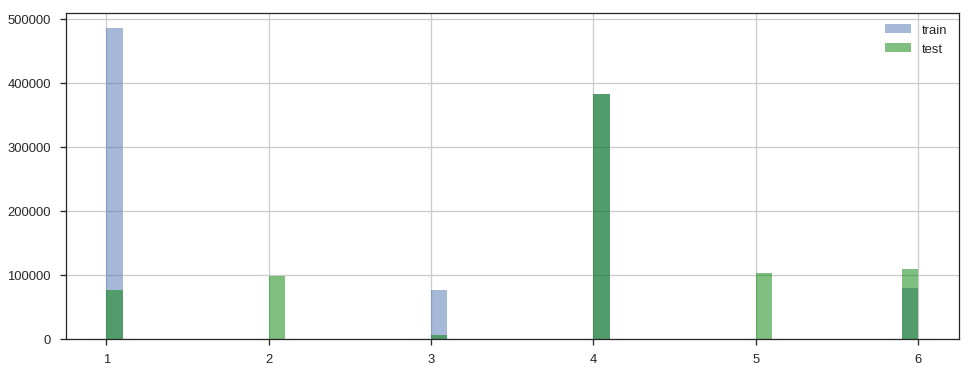

In [51]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'no_of_sections'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'no_of_sections'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

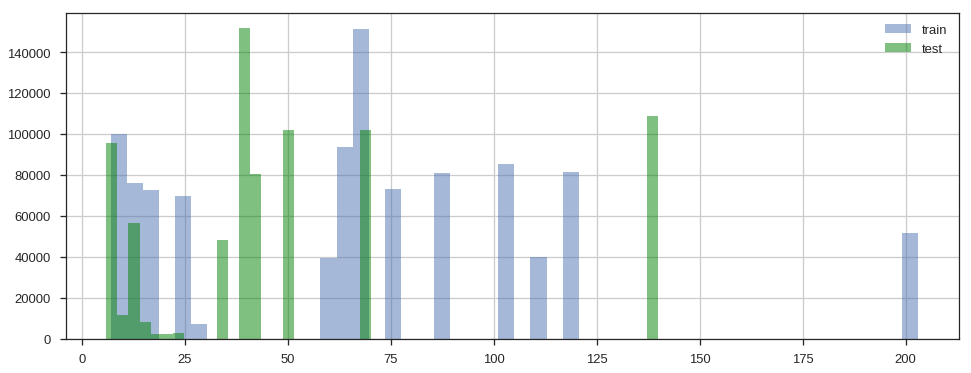

In [50]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'total_links'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'total_links'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

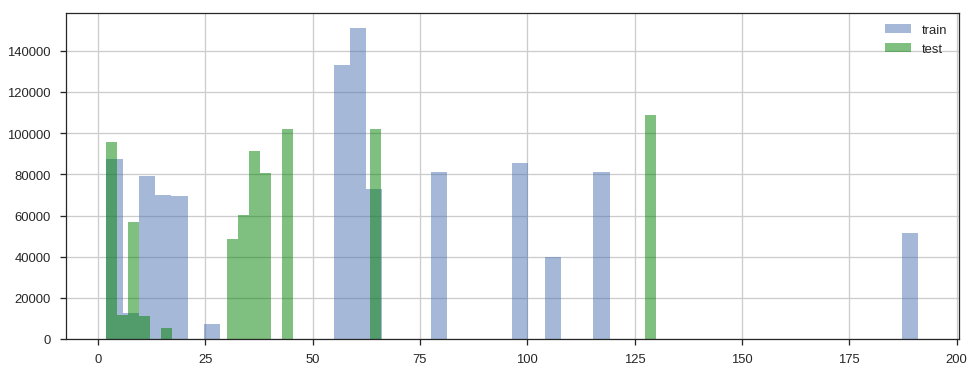

In [49]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'no_of_internal_links'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'no_of_internal_links'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

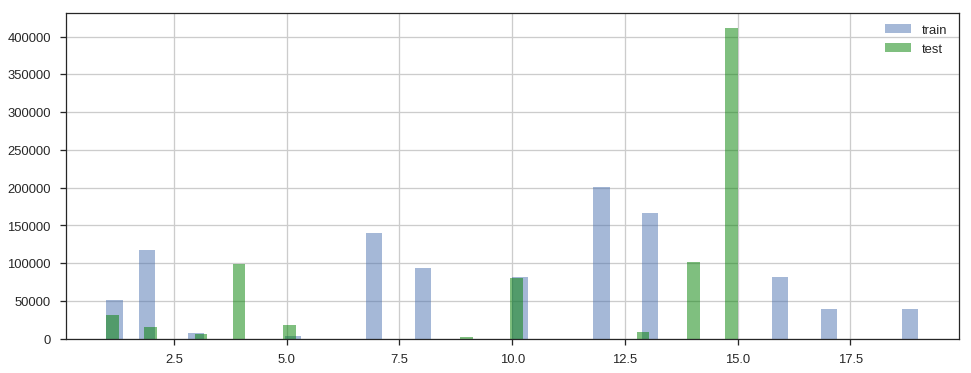

In [48]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'no_of_images'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'no_of_images'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

In [48]:
train_info.groupby('communication_type').size().sort_values(ascending=False)

communication_type
Newsletter         451053
Conference         332633
Upcoming Events    148964
Others              50936
Hackathon           33265
Webinar              3487
Corporate            2853
dtype: int64

In [65]:
test_info.groupby('communication_type').size().sort_values(ascending=False)

communication_type
Upcoming Events    302125
Newsletter         291706
Hackathon          144667
Corporate           35360
dtype: int64

** Datetime features **

In [6]:
train_info.loc[:, 'send_day']     = train_info.loc[:, 'send_date'].dt.day
train_info.loc[:, 'send_hour']    = train_info.loc[:, 'send_date'].dt.hour
train_info.loc[:, 'send_weekday'] = train_info.loc[:, 'send_date'].dt.weekday
train_info.loc[:, 'send_month']   = train_info.loc[:, 'send_date'].dt.month

test_info.loc[:, 'send_day']     = test_info.loc[:, 'send_date'].dt.day
test_info.loc[:, 'send_hour']    = test_info.loc[:, 'send_date'].dt.hour
test_info.loc[:, 'send_weekday'] = test_info.loc[:, 'send_date'].dt.weekday
test_info.loc[:, 'send_month']   = test_info.loc[:, 'send_date'].dt.month

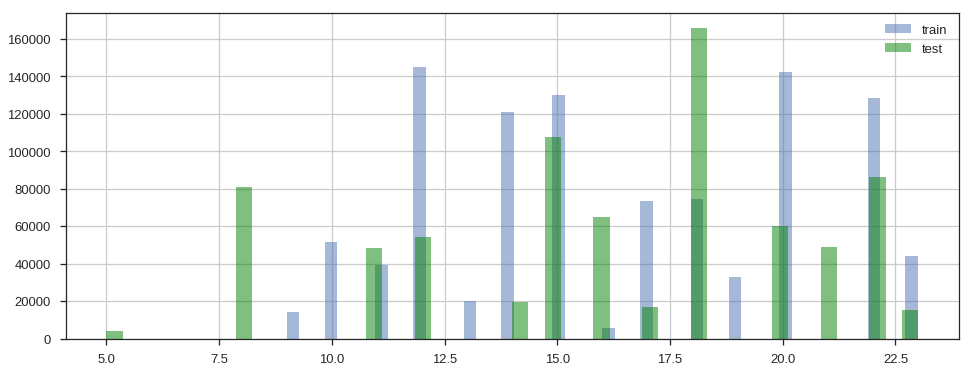

In [45]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'send_hour'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'send_hour'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

In [46]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'send_day'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'send_day'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

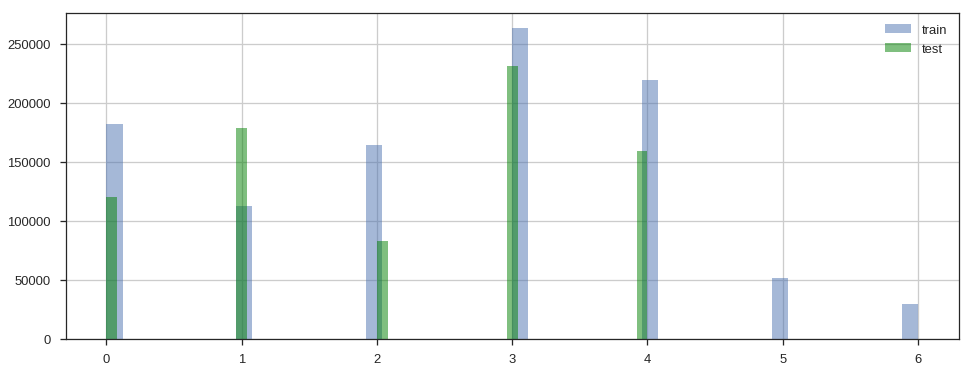

In [47]:
plt.figure(figsize=(16, 6))
train_info.loc[:, 'send_weekday'].hist(bins=50, alpha=.5, label='train')
test_info.loc[:, 'send_weekday'].hist(bins=50, color='g', alpha=.5, label='test')
plt.legend(loc='best');

## Bi-variate Relatioships

In [7]:
# Relationship between is_open and is_click
pd.crosstab(train_info.is_open, train_info.is_click)

is_click       0      1
is_open                
0         920401      0
1          90008  12782

### Explore Relationship between user id statistics and target ( is_open, is_click )

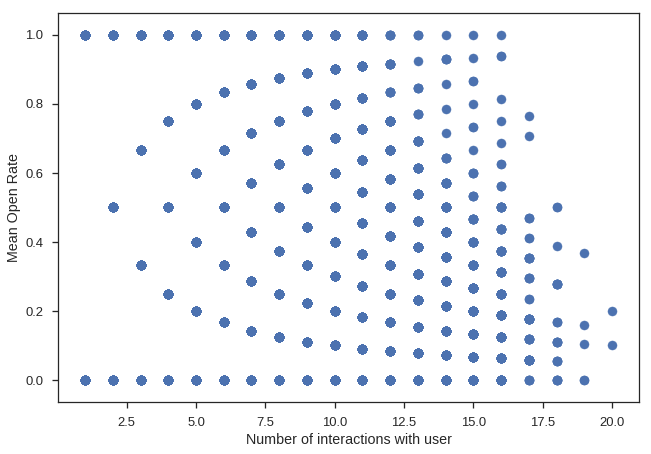

In [33]:
# count of times email has been sent before
user_id_grouped   = train_info.groupby('user_id')

plt.scatter(user_id_grouped.size(), user_id_grouped.is_open.mean())
plt.xlabel('Number of interactions with user')
plt.ylabel('Mean Open Rate');

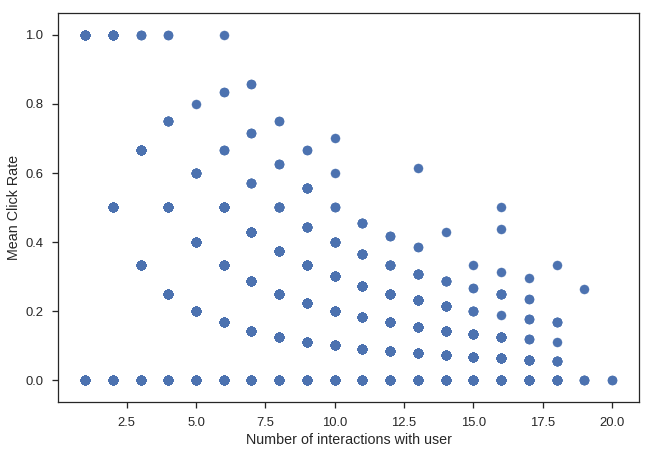

In [34]:
plt.scatter(user_id_grouped.size(), user_id_grouped.is_click.mean())
plt.xlabel('Number of interactions with user')
plt.ylabel('Mean Click Rate');

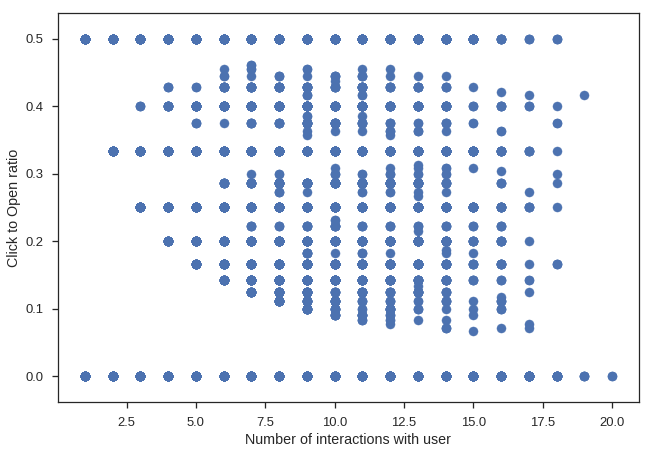

In [40]:
click_to_open = (user_id_grouped.is_click.sum() / (user_id_grouped.is_click.sum() + user_id_grouped.is_open.sum())).fillna(0)

plt.scatter(user_id_grouped.size(), click_to_open)
plt.xlabel('Number of interactions with user')
plt.ylabel('Click to Open ratio');

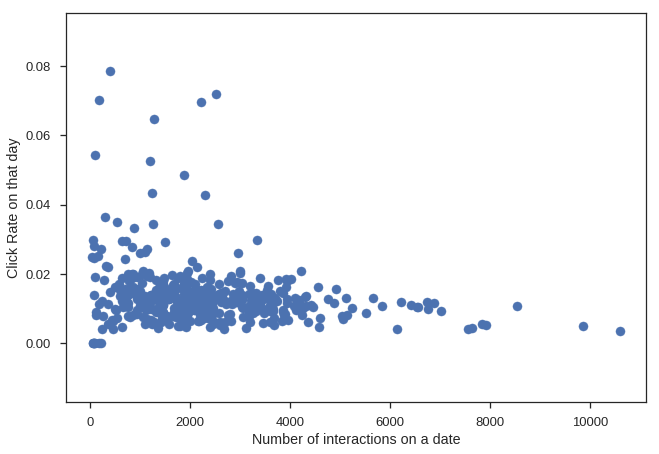

In [17]:
## How many interactions happened on that date ?
num_interactions_date = train_info.groupby('send_date').size()
mean_click            = train_info.groupby('send_date')['is_click'].mean()

plt.scatter(num_interactions_date, mean_click)
plt.xlabel('Number of interactions on a date')
plt.ylabel('Click Rate on that day');

## Plot features over time

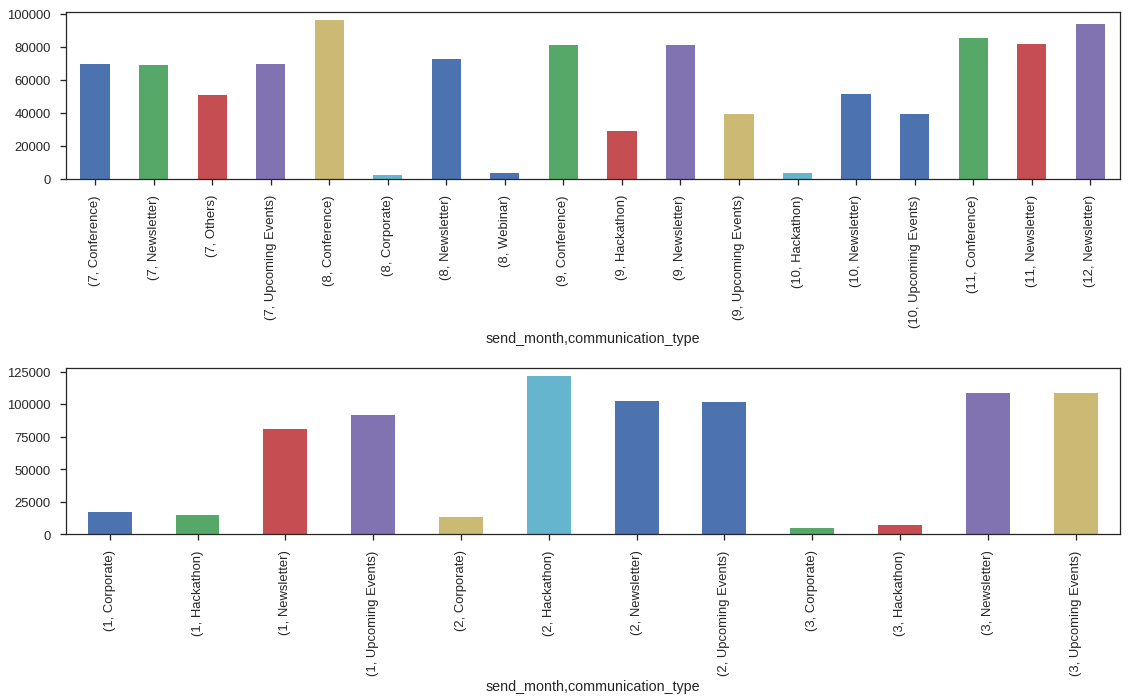

In [109]:
fig, ax = plt.subplots(2, figsize=(16, 10))
train_info.groupby(['send_month', 'communication_type']).size().plot(kind='bar', ax=ax[0])
test_info.groupby(['send_month', 'communication_type']).size().plot(kind='bar', ax=ax[1])
plt.tight_layout();

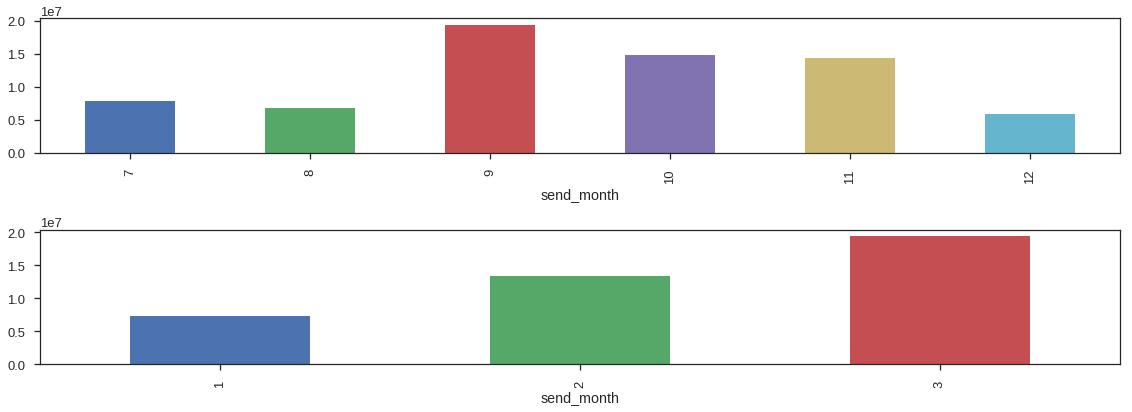

In [114]:
fig, ax = plt.subplots(2, figsize=(16, 6))
train_info.groupby('send_month')['total_links'].sum().plot(kind='bar', ax=ax[0])
test_info.groupby('send_month')['total_links'].sum().plot(kind='bar', ax=ax[1])

plt.tight_layout();

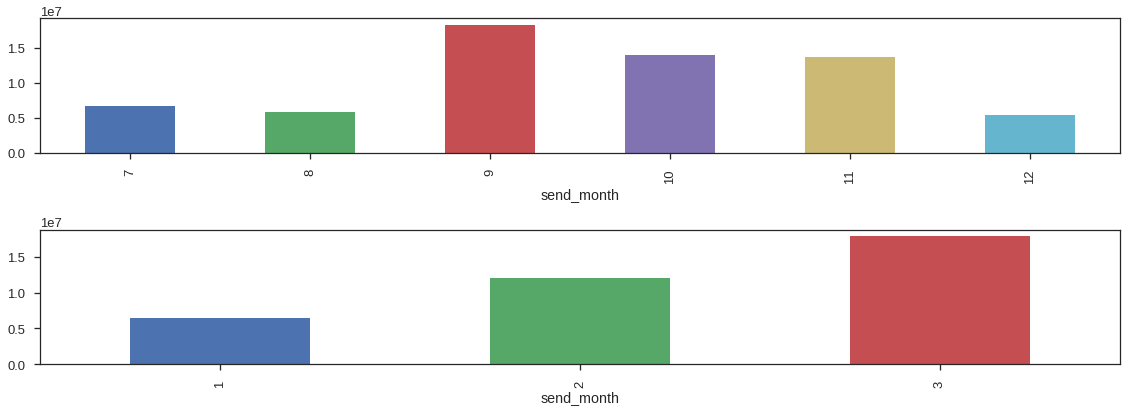

In [117]:
fig, ax = plt.subplots(2, figsize=(16, 6))
train_info.groupby('send_month')['no_of_internal_links'].sum().plot(kind='bar', ax=ax[0])
test_info.groupby('send_month')['no_of_internal_links'].sum().plot(kind='bar', ax=ax[1])

plt.tight_layout();

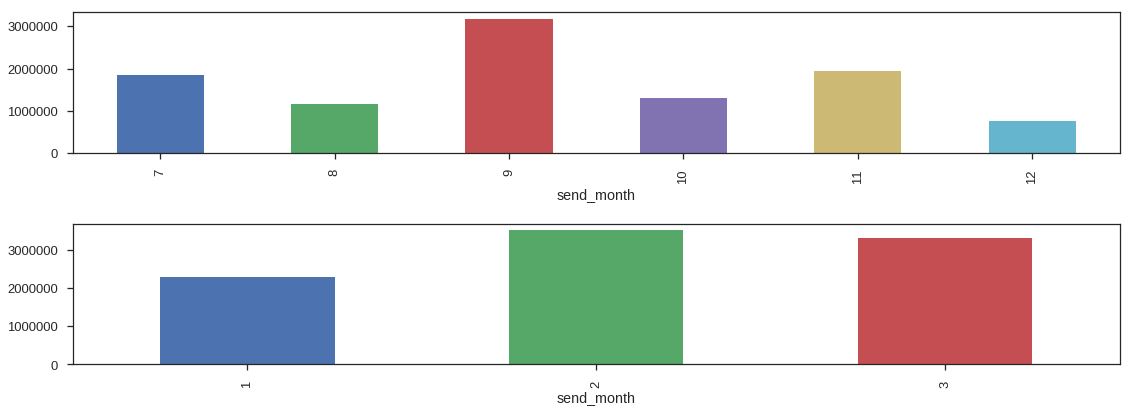

In [116]:
fig, ax = plt.subplots(2, figsize=(16, 6))
train_info.groupby('send_month')['no_of_images'].sum().plot(kind='bar', ax=ax[0])
test_info.groupby('send_month')['no_of_images'].sum().plot(kind='bar', ax=ax[1])

plt.tight_layout();

** Rolling target mean for communication type **

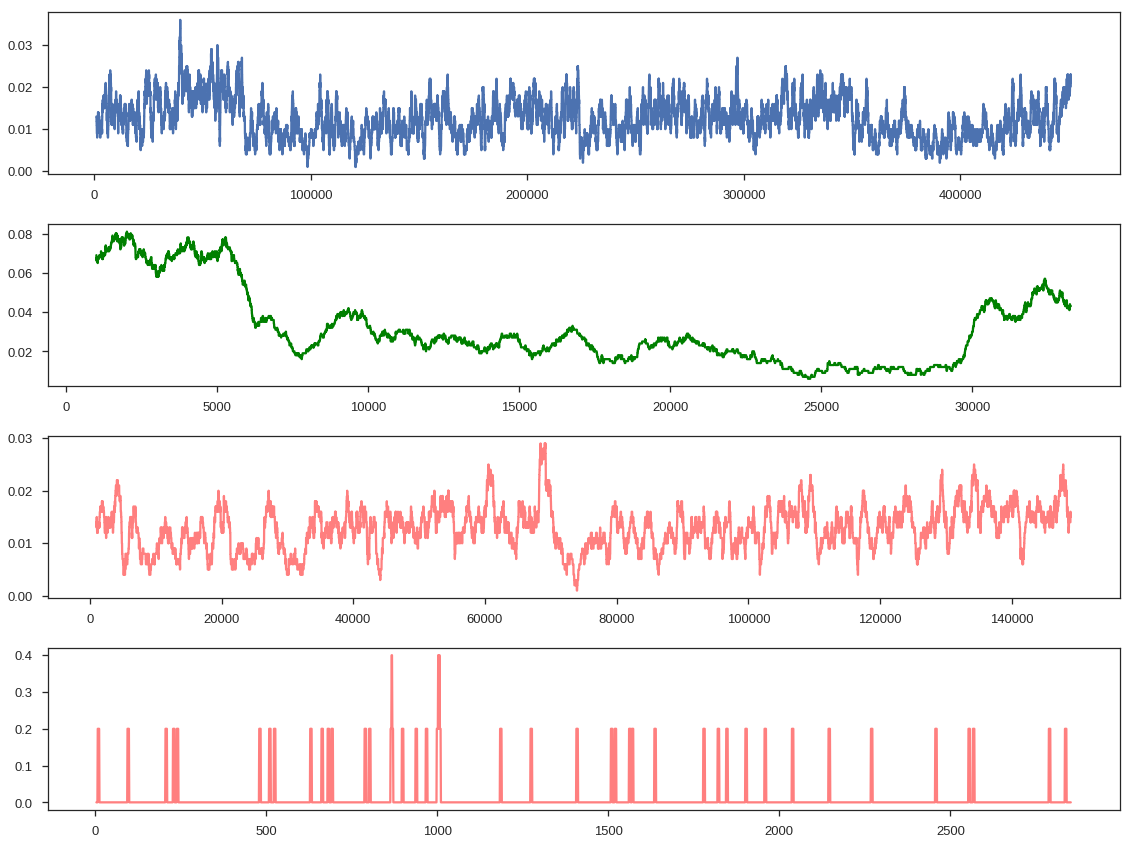

In [52]:
fig, ax = plt.subplots(4, figsize=(16, 12))

# Newsletter
newsletter_perf = train_info.loc[train_info.communication_type == 'Newsletter', ['is_click', 'send_date']]\
                            .sort_values(by='send_date').is_click.rolling(window=1000).mean()
newsletter_perf.index = np.arange(len(newsletter_perf))
newsletter_perf.plot(ax=ax[0], label='Newsletter')

# Hackathon
hackathon_perf = train_info.loc[train_info.communication_type == 'Hackathon', ['is_click', 'send_date']]\
                            .sort_values(by='send_date').is_click.rolling(window=1000).mean()
hackathon_perf.index = np.arange(len(hackathon_perf))
hackathon_perf.plot(c='g', ax=ax[1], label='Hackathon')

# Upcoming Events
upcoming_events_perf = train_info.loc[train_info.communication_type == 'Upcoming Events', ['is_click', 'send_date']]\
                            .sort_values(by='send_date').is_click.rolling(window=1000).mean()
upcoming_events_perf.index = np.arange(len(upcoming_events_perf))
upcoming_events_perf.plot(c='r', alpha=.5, ax=ax[2])

# Corporate Events
corporate_perf = train_info.loc[train_info.communication_type == 'Corporate', ['is_click', 'send_date']]\
                            .sort_values(by='send_date').is_click.rolling(window=5).mean()
corporate_perf.index = np.arange(len(corporate_perf))
corporate_perf.plot(c='r', alpha=.5, ax=ax[3])


plt.tight_layout();

In [58]:
train_info.loc[(train_info.communication_type == 'Hackathon'), ['send_date', 'is_click']]\
          .sort_values(by='send_date').iloc[:10]

send_date  is_click
340514 2017-09-11 18:00:00         1
605701 2017-09-11 18:00:00         0
236817 2017-09-11 18:00:00         0
585131 2017-09-11 18:00:00         0
836152 2017-09-11 18:00:00         1
301455 2017-09-11 18:00:00         0
236469 2017-09-11 18:00:00         0
365067 2017-09-11 18:00:00         1
302924 2017-09-11 18:00:00         0
235586 2017-09-11 18:00:00         0

In [92]:
%%time

def num_clicks_last_100(row):
    return row.sort_values(by='send_date').iloc[-100:].is_click.sum()

def num_clicks_last_500(row):
    return row.sort_values(by='send_date').iloc[-500:].is_click.sum()

def num_clicks_last_1000(row):
    return row.sort_values(by='send_date').iloc[-1000:].is_click.sum()

xx = train_info.groupby('communication_type').apply(num_clicks_last_100)
yy = train_info.groupby('communication_type').apply(num_clicks_last_500)
zz = train_info.groupby('communication_type').apply(num_clicks_last_1000)

CPU times: user 2.08 s, sys: 171 ms, total: 2.25 s
Wall time: 2.25 s
Parser   : 313 ms


In [31]:
a = pd.DataFrame({'num': np.arange(10)}); a.head()

num
0    0
1    1
2    2
3    3
4    4

In [34]:
a.rolling(window=5).sum()

num
0   NaN
1   NaN
2   NaN
3   NaN
4  10.0
5  15.0
6  20.0
7  25.0
8  30.0
9  35.0

In [37]:
_.shape, train_info.shape

((1023191,), (1023191, 12))

In [76]:
conference_rolling_sum = train_info.groupby('communication_type')\
                                   .apply(lambda row: row.is_click.rolling(window=1000).sum().fillna(0))
conference_rolling_sum = conference_rolling_sum.reset_index(level=0)

In [79]:
train_info.groupby('communication_type').size()

communication_type
Conference         332633
Corporate            2853
Hackathon           33265
Newsletter         451053
Others              50936
Upcoming Events    148964
Webinar              3487
dtype: int64

In [73]:
conference_rolling_sum.groupby('communication_type').apply(lambda x: x.is_click.values[-1])

communication_type
Conference         1.0
Corporate          1.0
Hackathon          6.0
Newsletter         3.0
Others             4.0
Upcoming Events    1.0
Webinar            5.0
dtype: float64

In [75]:
conference_rolling_sum.groupby('communication_type').apply(lambda x: x.is_click.values[-1])

communication_type
Conference          3.0
Corporate           5.0
Hackathon          16.0
Newsletter          8.0
Others              8.0
Upcoming Events     7.0
Webinar            22.0
dtype: float64

In [77]:
conference_rolling_sum.groupby('communication_type').apply(lambda x: x.is_click.values[-1])

communication_type
Conference          8.0
Corporate          13.0
Hackathon          32.0
Newsletter         14.0
Others             19.0
Upcoming Events     9.0
Webinar            37.0
dtype: float64

In [97]:
ss.communication_type.unique()

array(['Conference', 'Corporate', 'Hackathon', 'Newsletter', 'Others',
       'Upcoming Events', 'Webinar'], dtype=object)

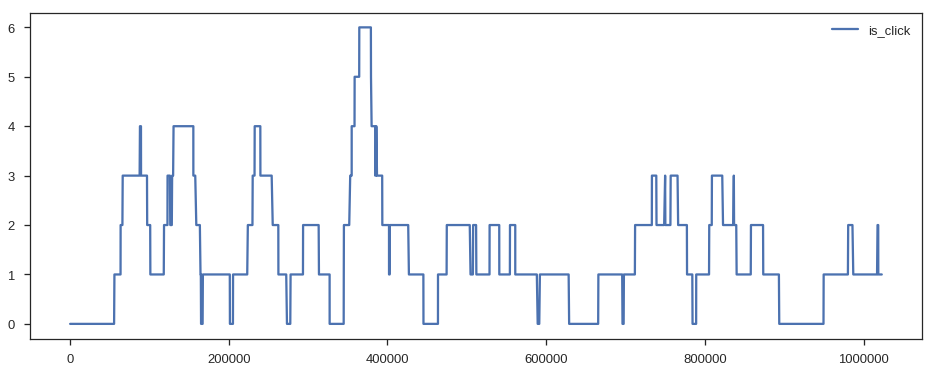

In [68]:
fig, ax = plt.subplots(1, figsize=(16, 6))
conference_rolling_sum.loc[conference_rolling_sum.communication_type == 'Corporate'].plot(ax=ax);

In [40]:
train_info.iloc[[5, 8, 15]]

id  user_id  campaign_id           send_date  is_open  is_click  \
5   49_219916   219916           49 2017-09-28 15:53:00        0         0   
8   49_185813   185813           49 2017-09-28 15:38:00        0         0   
15  36_202143   202143           36 2017-08-03 17:13:00        0         0   

                                              subject communication_type  \
5   Register @ DataHack Summit 2017 - India's Larg...         Conference   
8   Register @ DataHack Summit 2017 - India's Larg...         Conference   
15  Dr Kirk Borne of Booz Allen Hamilton, to keyno...         Conference   

    total_links  no_of_internal_links  no_of_images  no_of_sections  
5           119                   117            16               1  
8           119                   117            16               1  
15           13                    11             2               1

** Rolling target mean over time **

In [130]:
plt.figure(figsize=(16, 6))
rolling_target = train_info.sort_values('send_date').is_click.rolling(window=1000).mean()
rolling_target.index = np.arange(len(rolling_target))
rolling_target.plot()
plt.axhline(train_info.is_click.mean(), c='k');

## Relationship with target

### Communication Type and Month 

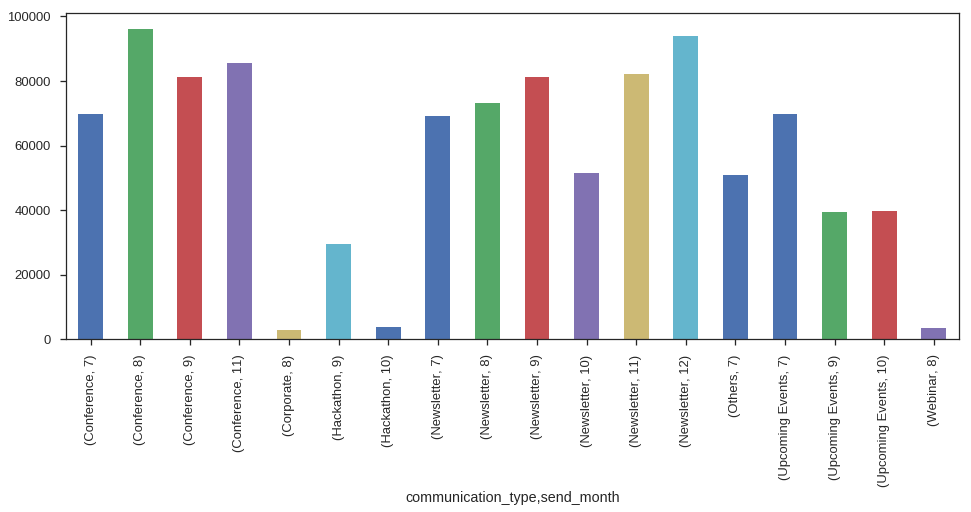

In [160]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_month']).size().plot(kind='bar');

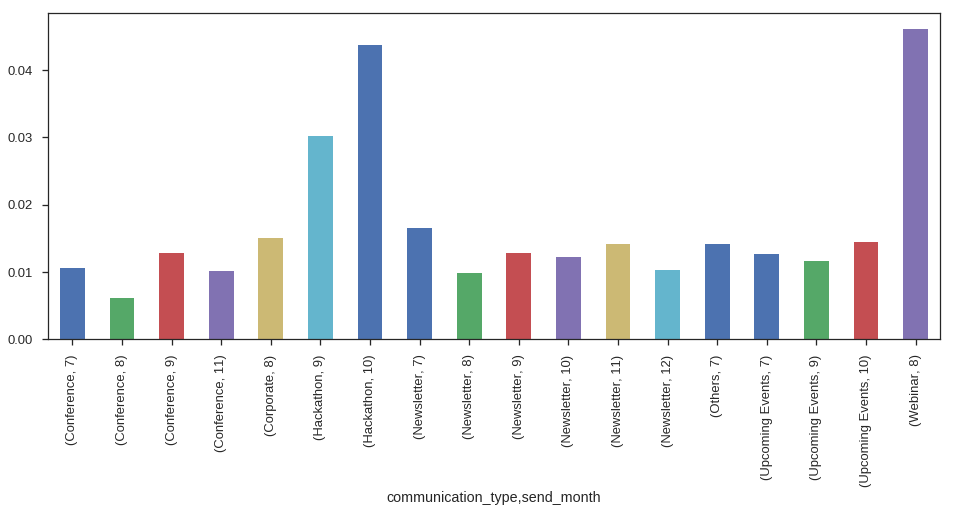

In [158]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_month'])['is_click'].mean().plot(kind='bar');

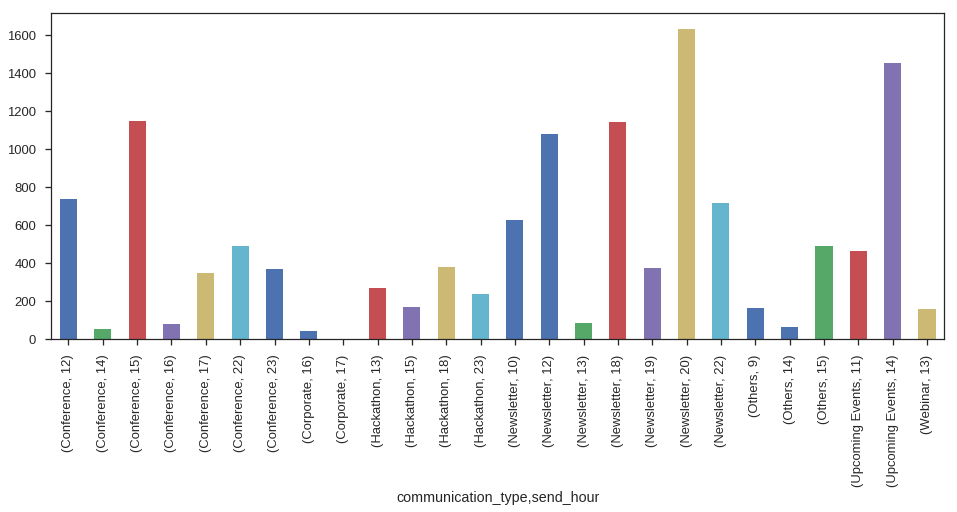

In [8]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_hour'])['is_click'].sum().plot(kind='bar');

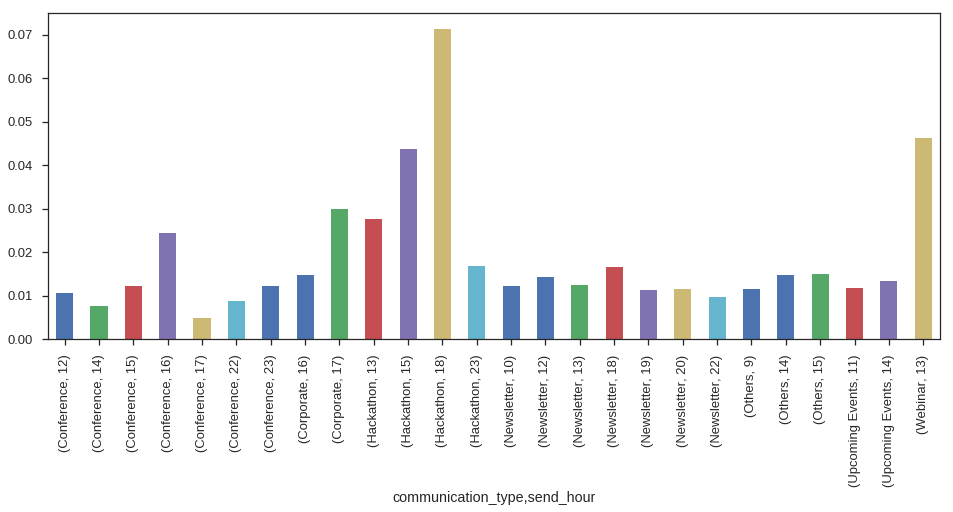

In [7]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_hour'])['is_click'].mean().plot(kind='bar');

In [9]:
train_info.groupby(['communication_type', 'send_hour']).size()

communication_type  send_hour
Conference          12            69624
                    14             7232
                    15            93739
                    16             3192
                    17            73415
                    22            55253
                    23            30178
Corporate           16             2786
                    17               67
Hackathon           13             9831
                    15             3882
                    18             5322
                    23            14230
Newsletter          10            51456
                    12            75201
                    13             6959
                    18            69129
                    19            33019
                    20           142177
                    22            73112
Others              9             14206
                    14             4377
                    15            32353
Upcoming Events     11            39498
          

In [10]:
test_info.groupby(['communication_type', 'send_hour']).size()

communication_type  send_hour
Corporate           15            19524
                    16            15836
Hackathon           5              4121
                    12            54522
                    14            19391
                    16            49256
                    17             3460
                    18            13917
Newsletter          8             80709
                    20            60129
                    21            48733
                    22            86574
                    23            15561
Upcoming Events     11            48322
                    15            88366
                    17            13545
                    18           151892
dtype: int64

### Communication Type, Weekday

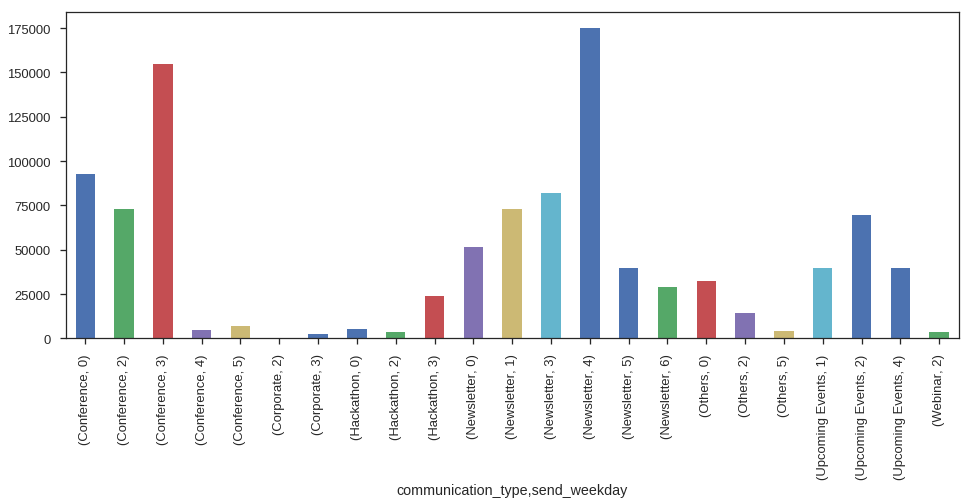

In [52]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_weekday']).size().plot(kind='bar');

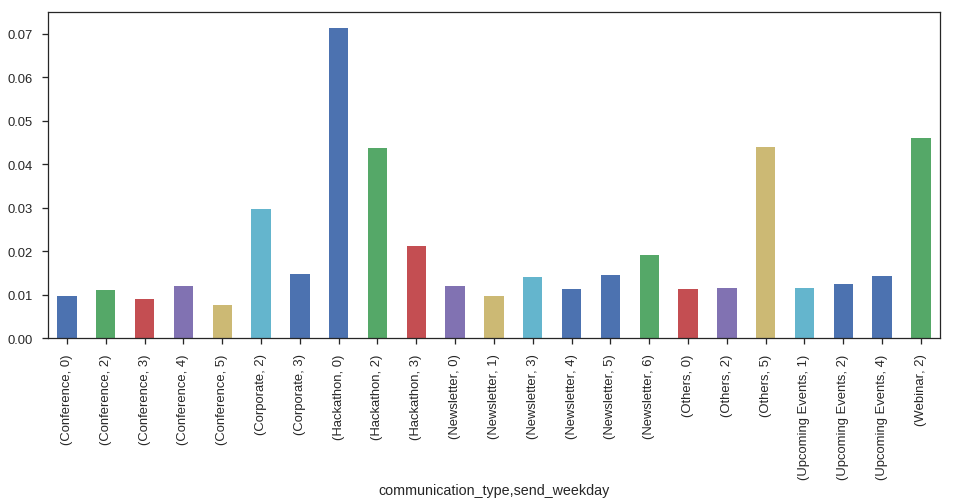

In [53]:
plt.figure(figsize=(16, 6))
train_info.groupby(['communication_type', 'send_weekday'])['is_click'].mean().plot(kind='bar');

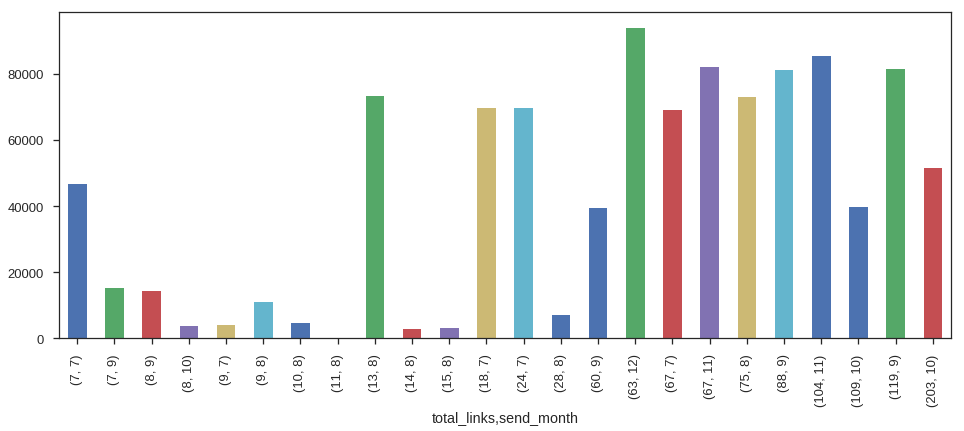

In [162]:
plt.figure(figsize=(16, 6))
train_info.groupby(['total_links', 'send_month']).size().plot(kind='bar');

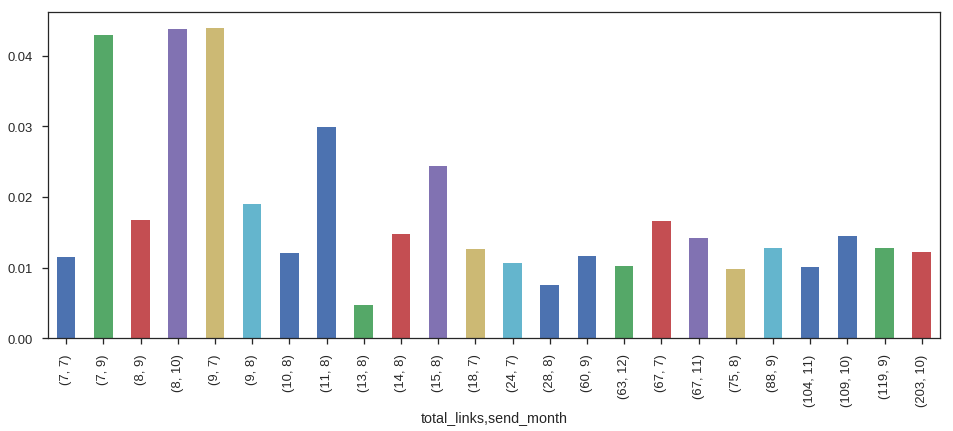

In [164]:
plt.figure(figsize=(16, 6))
train_info.groupby(['total_links', 'send_month'])['is_click'].mean().plot(kind='bar');

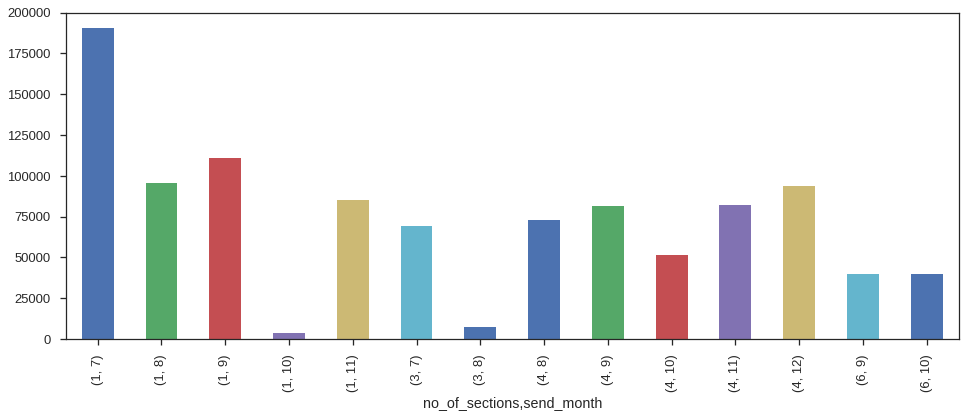

In [165]:
plt.figure(figsize=(16, 6))
train_info.groupby(['no_of_sections', 'send_month']).size().plot(kind='bar');

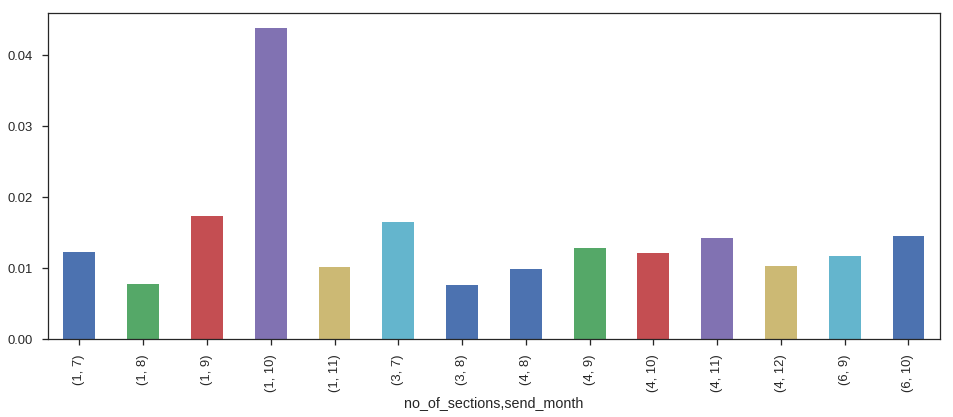

In [166]:
plt.figure(figsize=(16, 6))
train_info.groupby(['no_of_sections', 'send_month'])['is_click'].mean().plot(kind='bar');

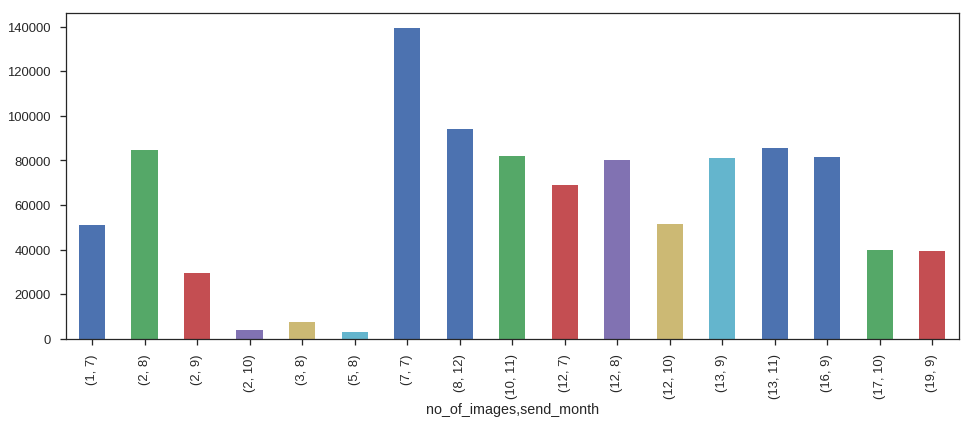

In [167]:
plt.figure(figsize=(16, 6))
train_info.groupby(['no_of_images', 'send_month']).size().plot(kind='bar');

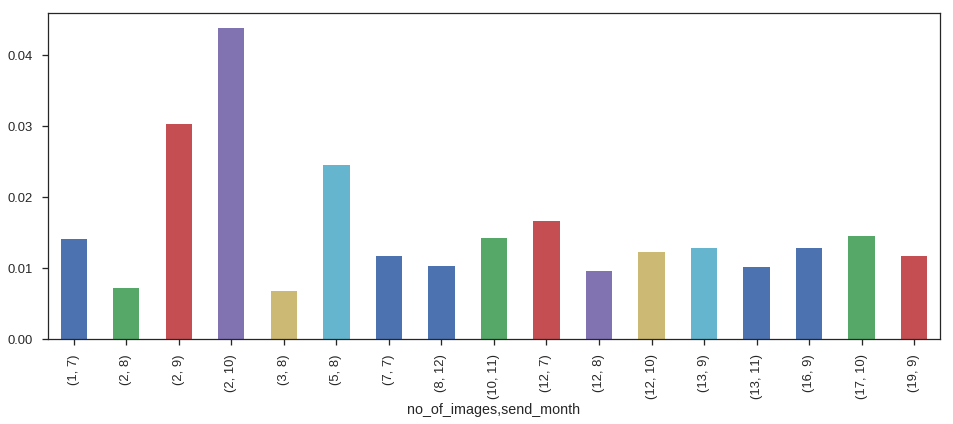

In [168]:
plt.figure(figsize=(16, 6))
train_info.groupby(['no_of_images', 'send_month'])['is_click'].mean().plot(kind='bar');

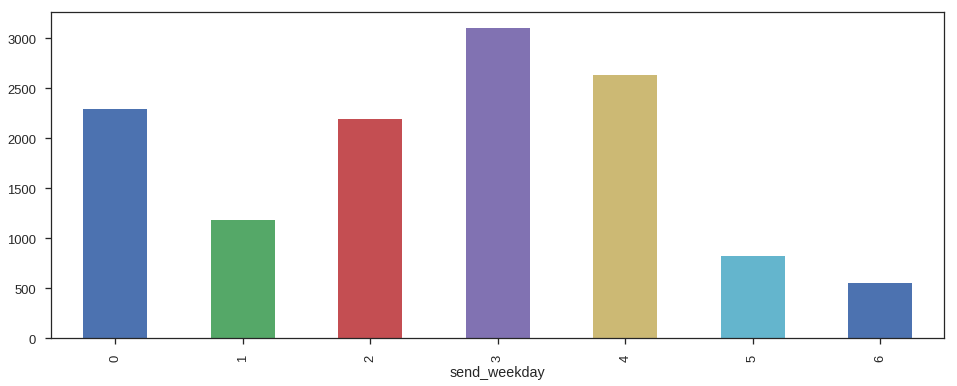

In [19]:
plt.figure(figsize=(16, 6))
train_info.groupby('send_weekday')['is_click'].sum().plot(kind='bar');

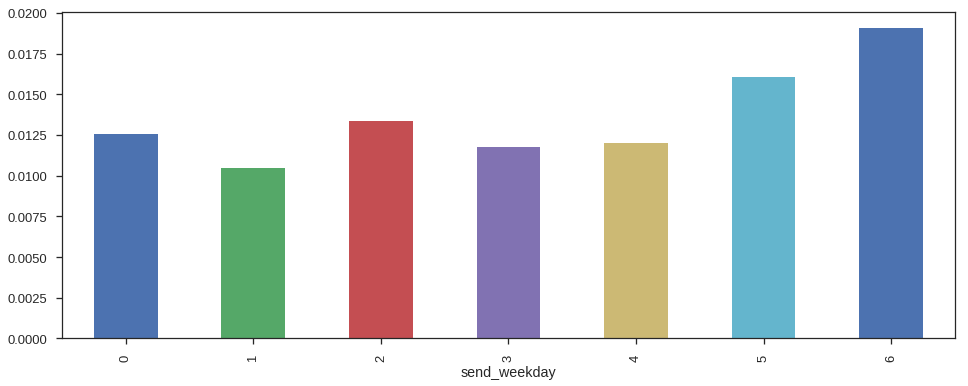

In [20]:
plt.figure(figsize=(16, 6))
train_info.groupby('send_weekday')['is_click'].mean().plot(kind='bar');

### Campaign Id

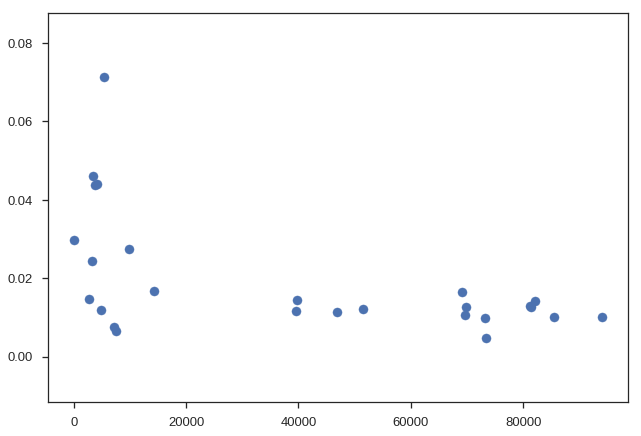

In [5]:
plt.scatter(train_info.groupby('campaign_id')['is_click'].size(),
            train_info.groupby('campaign_id')['is_click'].mean()
           );

In [14]:
train_info.groupby('campaign_id')['is_click'].mean()

campaign_id
29    0.016549
30    0.012615
31    0.024436
32    0.010600
33    0.011449
34    0.009807
35    0.043921
36    0.004767
37    0.006482
38    0.007605
39    0.046171
40    0.012028
41    0.014716
42    0.012824
43    0.029851
44    0.011697
45    0.071402
46    0.027566
47    0.016725
48    0.012166
49    0.012758
50    0.014455
51    0.043792
52    0.014192
53    0.010090
54    0.010251
Name: is_click, dtype: float64

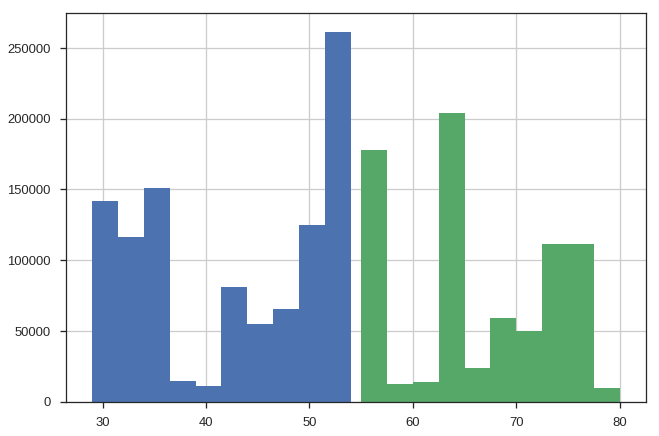

In [8]:
train_info.campaign_id.hist()
test_info.campaign_id.hist();

In [10]:
train_info.groupby(['campaign_id', 'communication_type']).size()

campaign_id  communication_type
29           Newsletter            69129
30           Upcoming Events       69756
31           Conference             3192
32           Conference            69624
33           Others                46815
34           Newsletter            73112
35           Others                 4121
36           Conference            73415
37           Conference             7559
38           Conference             7232
39           Webinar                3487
40           Conference             4822
41           Corporate              2786
42           Newsletter            81253
43           Corporate                67
44           Upcoming Events       39498
45           Hackathon              5322
46           Hackathon              9831
47           Hackathon             14230
48           Newsletter            51456
49           Conference            81358
50           Upcoming Events       39710
51           Hackathon              3882
52           Newsletter  

In [19]:
train_info.loc[train_info.communication_type == 'Corporate', 'campaign_id'].unique()

array([41, 43])

## CrossTabulation

### No of Images

In [221]:
ss = pd.crosstab(train_info.no_of_images, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Number of images, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Number of images, Information Value:  0.014969201551045436


### Number of Sections

In [222]:
ss = pd.crosstab(train_info.no_of_sections, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Number of sections, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Number of sections, Information Value:  0.005832304208930628


### Communication Type

In [223]:
ss = pd.crosstab(train_info.communication_type, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Communication Type, Information Value: ',((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Communication Type, Information Value:  0.08096256382008232


### Total Number of Clicks

In [237]:
ss = pd.crosstab(pd.cut(train_info.total_links, bins=4, labels=np.arange(0, 4)), train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Total number of clicks, Information Value: ',((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Total number of clicks, Information Value:  0.0012767602551007424


### Send Hour

In [243]:
ss = pd.crosstab(train_info.send_hour, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Send Hour, Information Value: ',((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Send Hour, Information Value:  0.09656432234883032


### Send Weekday

In [244]:
ss = pd.crosstab(train_info.send_weekday, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Send Weekday, Information Value: ',((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Send Weekday, Information Value:  0.015478935745032268


### Send Day

In [245]:
ss = pd.crosstab(train_info.send_day, train_info.is_click)
ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Send Day, Information Value: ',((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Send Day, Information Value:  0.14416695170791155


## Cross Validation Strategies

- Random Holdout sample.
- Time based Holdout sample.
- Sample based on communication type.
- Sample based on communication type and restriction on total number of links in an email.
- Sample based on communication type and restriction on days on which email was sent.
- Sample based on communication type and restriction on total number of links and weekdays on which email was sent.
- Sample based on commmunication type and time based split.

### Random Holdout Sample

In [259]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(train_info, train_info.is_click))

In [263]:
%%time

tr       = train_info.iloc[itr]
tr.index = np.arange(len(tr))

te       = train_info.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/random/tr.feather')
te.to_feather('../data/processed/val/random/val.feather')
    
joblib.dump(itr, '../data/processed/val/random/tr_ind.pkl')
joblib.dump(ite, '../data/processed/val/random/val_ind.pkl')

CPU times: user 634 ms, sys: 124 ms, total: 758 ms
Wall time: 748 ms


### Sample based on communication type

In [8]:
comm_type_in_test   = train_info.loc[train_info.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :]
other_type_in_train = train_info.loc[~train_info.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :] 

In [13]:
sss      = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(comm_type_in_test, comm_type_in_test.is_click))

In [19]:
tr       = pd.concat((comm_type_in_test.iloc[itr], other_type_in_train))
tr.index = np.arange(len(tr))

te       = comm_type_in_test.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/ctype/tr.feather')
te.to_feather('../data/processed/val/ctype/val.feather')

### Sample based on communication type and restriction on number on total number of links.

In [5]:
train_info_sub = train_info.loc[train_info.total_links < 140]

comm_type_in_test   = train_info_sub.loc[train_info_sub.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :]
other_type_in_train = train_info_sub.loc[~train_info_sub.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :] 

In [6]:
sss      = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(comm_type_in_test, comm_type_in_test.is_click))

In [7]:
tr       = pd.concat((comm_type_in_test.iloc[itr], other_type_in_train))
tr.index = np.arange(len(tr))

te       = comm_type_in_test.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/ctypev1/tr.feather')
te.to_feather('../data/processed/val/ctypev1/val.feather')

train_info_sub.index = np.arange(len(train_info_sub))
train_info_sub.to_feather('../data/processed/trainv1.feather')

### Sample based on communication type and restriction on days on which mailer was sent.

In [10]:
mask = train_info.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']) &\
       train_info.send_date.dt.day.isin([1,  2,  5, 19,  7, 12,  6, 16,  9, 18, 10,  8, 11, 13, 22, 15, 24])

comm_type_in_test   = train_info.loc[mask, :]
other_type_in_train = train_info.loc[~train_info.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']) &\
                                         ~train_info.send_date.dt.day.isin([1,  2,  5, 19,  7, 12,  6, 16,  9, 18, 10,  8, 11, 13, 22, 15, 24])
                                         , :] 

In [16]:
sss      = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(comm_type_in_test, comm_type_in_test.is_click))

In [17]:
tr       = pd.concat((comm_type_in_test.iloc[itr], other_type_in_train))
tr.index = np.arange(len(tr))

te       = comm_type_in_test.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/ctypev2/tr.feather')
te.to_feather('../data/processed/val/ctypev2/val.feather')

### Sample based on communication type and don't include other communication types in the training set.

In [5]:
comm_type_in_test = train_info.loc[train_info.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :]

In [6]:
sss      = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(comm_type_in_test, comm_type_in_test.is_click))

In [7]:
tr       = comm_type_in_test.iloc[itr]
tr.index = np.arange(len(tr))

te       = comm_type_in_test.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/ctypev3/tr.feather')
te.to_feather('../data/processed/val/ctypev3/val.feather')

comm_type_in_test.index = np.arange(len(comm_type_in_test))
comm_type_in_test.to_feather('../data/processed/trainv3.feather')

### Sample based on communication type and restriction on total number of links and weekdays on which email was sent.

In [37]:
train_info_sub = train_info.loc[(train_info.total_links < 140) & (train_info.send_weekday.isin([0, 1, 2, 3, 4]))]

comm_type_in_test   = train_info_sub.loc[train_info_sub.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :]
other_type_in_train = train_info_sub.loc[~train_info_sub.communication_type.isin(['Newsletter', 'Upcoming Events', 'Hackathon', 'Corporate']), :] 

In [38]:
sss      = StratifiedShuffleSplit(n_splits=1, random_state=SEED)
itr, ite = next(sss.split(comm_type_in_test, comm_type_in_test.is_click))

In [40]:
tr       = pd.concat((comm_type_in_test.iloc[itr], other_type_in_train))
tr.index = np.arange(len(tr))

te       = comm_type_in_test.iloc[ite]
te.index = np.arange(len(te))

tr.to_feather('../data/processed/val/ctypev4/tr.feather')
te.to_feather('../data/processed/val/ctypev4/val.feather')

train_info_sub.index = np.arange(len(train_info_sub))
train_info_sub.to_feather('../data/processed/trainv4.feather')

### Sample based on communication type and time based split.

In [36]:
%%time

upcoming_events    = train_info.loc[train_info.communication_type == 'Upcoming Events']
upcoming_events_tr = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([7, 8])]
upcoming_events_te = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([9])]

newsletter    = train_info.loc[train_info.communication_type == 'Newsletter']
newsletter_tr = newsletter.loc[newsletter.send_date.dt.month.isin([7, 8, 9, 10, 11])]
newsletter_te = newsletter.loc[newsletter.send_date.dt.month.isin([12])]

hackathon    = train_info.loc[train_info.communication_type == 'Hackathon']
hackathon_tr = hackathon.loc[hackathon.send_date.dt.month.isin([9])]
hackathon_te = hackathon.loc[hackathon.send_date.dt.month.isin([10])]

corporate    = train_info.loc[train_info.communication_type == 'Corporate']
corporate_tr = corporate.sort_values(by='send_date').iloc[:int(3 * len(corporate) / 4)]
corporate_te = corporate.sort_values(by='send_date').iloc[int(3 * len(corporate) / 4):]


tr = pd.concat((upcoming_events_tr, newsletter_tr, hackathon_tr, corporate_tr,
                train_info.loc[train_info.communication_type.isin(['Conference', 'Others', 'Webinar'])]
               )).sort_values(by='send_date').sample(frac=1.)

te = pd.concat((upcoming_events_te, newsletter_te, hackathon_te, corporate_te)).sample(frac=1.)

tr.index = np.arange(len(tr))
te.index = np.arange(len(te))

print(len(set(tr.user_id) & set(te.user_id)) / te.user_id.nunique())

tr.to_feather('../data/processed/val/ctypev7/tr.feather')
te.to_feather('../data/processed/val/ctypev7/val.feather')

upcoming te  (21891, 12)
newsletter_te  (26171, 12)
hackathon_te  (1706, 12)
corporate_te  (713, 12)
Upcoming: 148964
Newsletter: 451053
Hackathon: 33265
Corporate: 2853

0.8515612058969687


### Sample based on communication type and time based split making sure user ratio is respected

In [37]:
# %%time

upcoming_events    = train_info.loc[train_info.communication_type == 'Upcoming Events']
upcoming_events_tr = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([7, 8])]
upcoming_events_te = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([9])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(upcoming_events_tr.user_id) & set(upcoming_events_te.user_id)))\
                         .sample(frac=.1))
sample_user_ids    = list(set(sample_user_ids) | (set(upcoming_events_te.user_id) - set(upcoming_events_tr.user_id)))
upcoming_events_te = upcoming_events_te.loc[upcoming_events_te.user_id.isin(sample_user_ids)]


newsletter    = train_info.loc[train_info.communication_type == 'Newsletter']
newsletter_tr = newsletter.loc[newsletter.send_date.dt.month.isin([7, 8, 9, 10, 11])]
newsletter_te = newsletter.loc[newsletter.send_date.dt.month.isin([12])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(newsletter_tr.user_id) & set(newsletter_te.user_id))).sample(frac=.1))
sample_user_ids    = list(set(sample_user_ids) | (set(newsletter_te.user_id) - set(newsletter_tr.user_id)))
newsletter_te      = newsletter_te.loc[newsletter_te.user_id.isin(sample_user_ids)]


hackathon    = train_info.loc[train_info.communication_type == 'Hackathon']
hackathon_tr = hackathon.loc[hackathon.send_date.dt.month.isin([9])]
hackathon_te = hackathon.loc[hackathon.send_date.dt.month.isin([10])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(hackathon_tr.user_id) & set(hackathon_te.user_id))).sample(frac=.3))
sample_user_ids    = list(set(sample_user_ids) | (set(hackathon_te.user_id) - set(hackathon_tr.user_id)))
hackathon_te       = hackathon_te.loc[hackathon_te.user_id.isin(sample_user_ids)]

corporate    = train_info.loc[train_info.communication_type == 'Corporate']
corporate_tr = corporate.sort_values(by='send_date').iloc[:int(3 * len(corporate) / 4)]
corporate_te = corporate.sort_values(by='send_date').iloc[int(3 * len(corporate) / 4):]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(corporate_tr.user_id) & set(corporate_te.user_id))).sample(frac=.3))
sample_user_ids    = list(set(sample_user_ids) | (set(corporate_te.user_id) - set(corporate_tr.user_id)))
corporate_te       = corporate_te.loc[corporate_te.user_id.isin(sample_user_ids)]

tr = pd.concat((upcoming_events_tr, newsletter_tr, hackathon_tr, corporate_tr,
                train_info.loc[train_info.communication_type.isin(['Conference', 'Others', 'Webinar'])]
               )).sort_values(by='send_date').sample(frac=1.)

te = pd.concat((upcoming_events_te, newsletter_te, hackathon_te, corporate_te)).sample(frac=1.)

tr.index = np.arange(len(tr))
te.index = np.arange(len(te))

print(len(set(tr.user_id) & set(te.user_id)) / te.user_id.nunique())

tr.to_feather('../data/processed/val/ctypev8/tr.feather')
te.to_feather('../data/processed/val/ctypev8/val.feather')

0.8514504765851637


### Sample based on communication type and time based split making sure user ratio is respected and communication type not in test set are not included

In [7]:
# %%time

upcoming_events    = train_info.loc[train_info.communication_type == 'Upcoming Events']
upcoming_events_tr = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([7, 8])]
upcoming_events_te = upcoming_events.loc[upcoming_events.send_date.dt.month.isin([9])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(upcoming_events_tr.user_id) & set(upcoming_events_te.user_id)))\
                         .sample(frac=.4))
sample_user_ids    = list(set(sample_user_ids) | (set(upcoming_events_te.user_id) - set(upcoming_events_tr.user_id)))
upcoming_events_te = upcoming_events_te.loc[upcoming_events_te.user_id.isin(sample_user_ids)]


newsletter    = train_info.loc[train_info.communication_type == 'Newsletter']
newsletter_tr = newsletter.loc[newsletter.send_date.dt.month.isin([7, 8, 9, 10, 11])]
newsletter_te = newsletter.loc[newsletter.send_date.dt.month.isin([12])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(newsletter_tr.user_id) & set(newsletter_te.user_id))).sample(frac=.4))
sample_user_ids    = list(set(sample_user_ids) | (set(newsletter_te.user_id) - set(newsletter_tr.user_id)))
newsletter_te      = newsletter_te.loc[newsletter_te.user_id.isin(sample_user_ids)]


hackathon    = train_info.loc[train_info.communication_type == 'Hackathon']
hackathon_tr = hackathon.loc[hackathon.send_date.dt.month.isin([9])]
hackathon_te = hackathon.loc[hackathon.send_date.dt.month.isin([10])]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(hackathon_tr.user_id) & set(hackathon_te.user_id))).sample(frac=.3))
sample_user_ids    = list(set(sample_user_ids) | (set(hackathon_te.user_id) - set(hackathon_tr.user_id)))
hackathon_te       = hackathon_te.loc[hackathon_te.user_id.isin(sample_user_ids)]

corporate    = train_info.loc[train_info.communication_type == 'Corporate']
corporate_tr = corporate.sort_values(by='send_date').iloc[:int(3 * len(corporate) / 4)]
corporate_te = corporate.sort_values(by='send_date').iloc[int(3 * len(corporate) / 4):]

# remove some user ids that are present in train set as well
sample_user_ids    = list(pd.Series(list(set(corporate_tr.user_id) & set(corporate_te.user_id))).sample(frac=.3))
sample_user_ids    = list(set(sample_user_ids) | (set(corporate_te.user_id) - set(corporate_tr.user_id)))
corporate_te       = corporate_te.loc[corporate_te.user_id.isin(sample_user_ids)]

tr = pd.concat((upcoming_events_tr, newsletter_tr, hackathon_tr, corporate_tr))\
       .sort_values(by='send_date').sample(frac=1.)

te = pd.concat((upcoming_events_te, newsletter_te, hackathon_te, corporate_te)).sample(frac=1.)

print(len(set(tr.user_id) & set(te.user_id)) / te.user_id.nunique())

pd.DataFrame({'tr_index': tr.index})\
  .to_csv('../data/interim/train_holdout_indices.csv', index=False)

pd.DataFrame({'te_index': te.index})\
  .to_csv('../data/interim/val_holdout_indices.csv', index=False)

tr.index = np.arange(len(tr))
te.index = np.arange(len(te))


# tr.to_feather('../data/processed/val/ctypev9/tr.feather')
# te.to_feather('../data/processed/val/ctypev9/val.feather')

0.7396737535119722


## Feature Engineering

In [15]:
traintest = pd.concat((train_info, test_info)); traintest.head()

campaign_id communication_type         id  is_click  is_open  no_of_images  \
0           42         Newsletter   42_14051       0.0      0.0            13   
1           52         Newsletter  52_134438       0.0      0.0            10   
2           33             Others  33_181789       0.0      0.0             1   
3           44    Upcoming Events  44_231448       0.0      0.0            19   
4           29         Newsletter  29_185580       0.0      0.0            12   

   no_of_internal_links  no_of_sections  num_emails_opened_before  \
0                    79               4                       0.0   
1                    62               4                       0.0   
2                     3               1                       0.0   
3                    56               6                       0.0   
4                    61               3                       0.0   

            send_date  total_links  user_id  
0 2017-09-01 19:55:00           88    14051  
1 2017-11-02 12:53:00           67   134438  
2 2017-07-24 15:15:00            7   181789  
3 2017-09-05 11:36:00           60   231448  
4 2017-07-01 18:01:00           67   185580

### Num Emails Sent

In [7]:
%%time

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

CPU times: user 347 ms, sys: 79.8 ms, total: 427 ms
Wall time: 427 ms


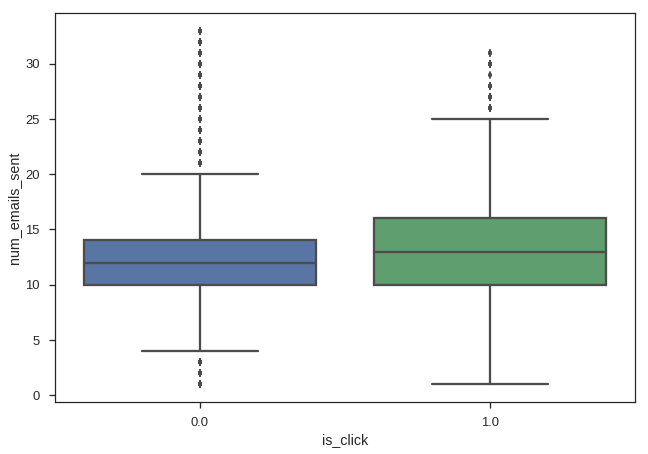

In [8]:
sns.boxplot(x=traintest.loc[traintest.is_click.notnull(), 'is_click'],
            y=traintest.loc[traintest.is_click.notnull(), 'num_emails_sent']
           );

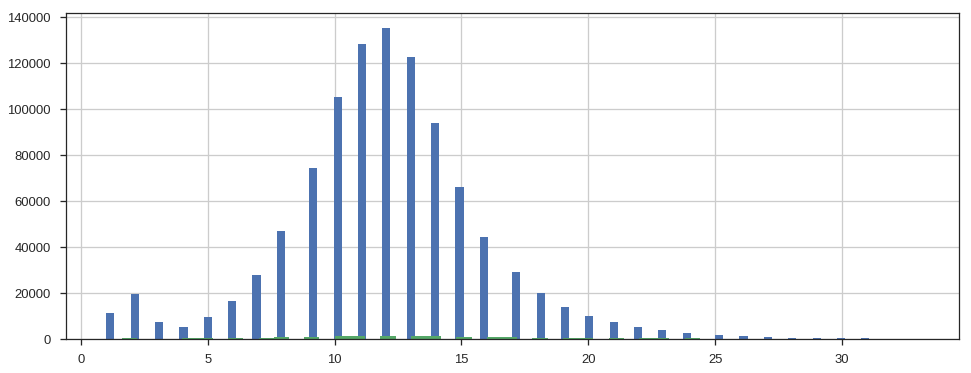

In [13]:
plt.figure(figsize=(16, 6))

traintest.loc[(traintest.is_click.notnull()) & (traintest.is_click == 0), 'num_emails_sent'].hist(bins=100)
traintest.loc[(traintest.is_click.notnull()) & (traintest.is_click == 1), 'num_emails_sent'].hist(bins=50);

In [17]:
%%time

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)

CPU times: user 4.55 s, sys: 140 ms, total: 4.69 s
Wall time: 4.69 s


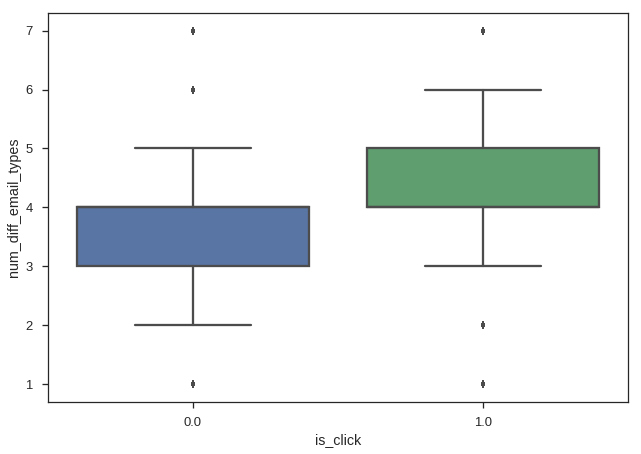

In [18]:
sns.boxplot(x=traintest.loc[traintest.is_click.notnull(), 'is_click'],
            y=traintest.loc[traintest.is_click.notnull(), 'num_diff_email_types']
           );

### Num emails opened before

In [11]:
# num emails opened before
num_emails_opened_before                      = train_info.groupby('user_id')['is_open'].mean()
train_info.loc[:, 'num_emails_opened_before'] = train_info.user_id.map(num_emails_opened_before)

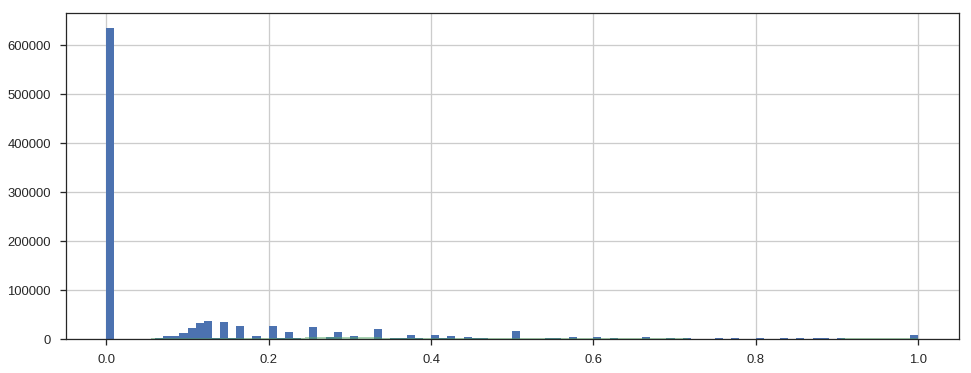

In [12]:
plt.figure(figsize=(16, 6))
train_info.loc[(train_info.is_click == 0), 'num_emails_opened_before'].hist(bins=100)
train_info.loc[(train_info.is_click == 1), 'num_emails_opened_before'].hist(alpha=.5);

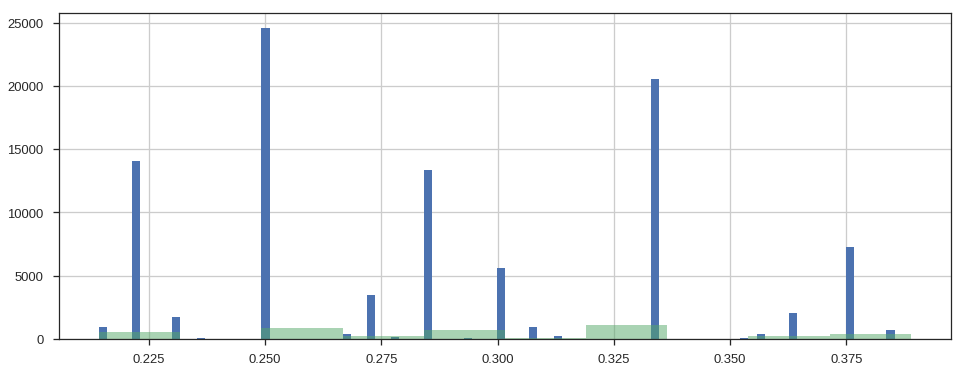

In [13]:
plt.figure(figsize=(16, 6))
train_info.loc[(train_info.is_click == 0) & ((train_info.num_emails_opened_before > .2) & (train_info.num_emails_opened_before < .4)), 'num_emails_opened_before'].hist(bins=100)
train_info.loc[(train_info.is_click == 1) & ((train_info.num_emails_opened_before > .2) & (train_info.num_emails_opened_before < .4)), 'num_emails_opened_before'].hist(alpha=.5);

### Most sent email type

In [96]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)

CPU times: user 2min 12s, sys: 998 ms, total: 2min 13s
Wall time: 2min 13s


In [97]:
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

In [99]:
ss = pd.crosstab(traintest.most_sent_type, traintest.is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.055572930888318786


### Number of emails of the type hackathon received by a user

In [13]:
%%time

def get_num_hackathon_emails(row):
    return len(row.loc[row.communication_type == 'Hackathon'])

num_hackathon_emails = train_info.groupby('user_id').apply(get_num_hackathon_emails)

CPU times: user 1min 36s, sys: 537 ms, total: 1min 37s
Wall time: 1min 38s


In [16]:
train_info.loc[:, 'num_hackathon_emails'] = train_info.user_id.map(num_hackathon_emails)

In [18]:
ss = pd.crosstab(train_info.num_hackathon_emails, train_info.is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.11517739883620429


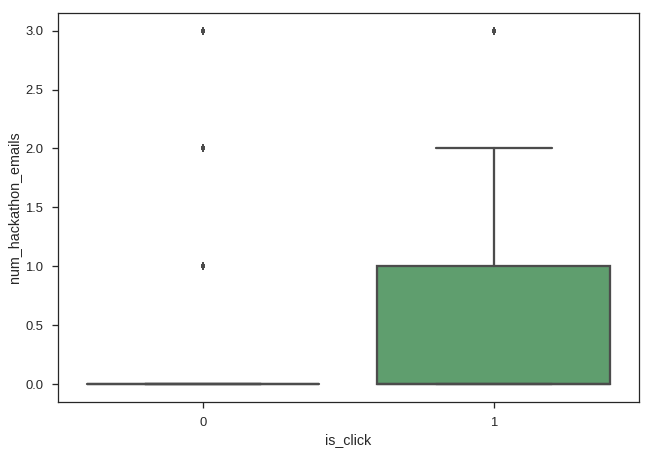

In [22]:
sns.boxplot(x=train_info.is_click,
            y=train_info.num_hackathon_emails
           );

In [23]:
train_info.groupby(num_hackathon_emails).is_click.mean()

0.0    0.013697
1.0    0.013226
2.0    0.015611
3.0    0.006667
Name: is_click, dtype: float64

In [27]:
train_info.groupby('user_id')['is_click'].sum().sort_values(ascending=False).iloc[:10]

user_id
65837     6
35310     6
221420    6
158510    5
91989     5
106949    5
72243     5
206278    5
42199     5
236699    5
Name: is_click, dtype: int64

In [28]:
train_info.loc[train_info.user_id == 65837, ['communication_type', 'send_date']].sort_values(by='send_date')

id  user_id  campaign_id           send_date  is_open  is_click  \
125946  42_65837    65837           42 2017-09-01 19:51:00        1         1   
167855  30_65837    65837           30 2017-07-05 14:00:00        1         1   
243100  29_65837    65837           29 2017-07-01 18:01:00        1         1   
259467  46_65837    65837           46 2017-09-14 13:37:00        1         0   
575177  52_65837    65837           52 2017-11-02 12:36:00        1         1   
728429  47_65837    65837           47 2017-09-21 23:31:00        1         1   
841332  50_65837    65837           50 2017-10-06 14:38:00        1         1   

                                                  subject communication_type  \
125946  [September] Exciting days ahead with DataHack ...         Newsletter   
167855  [July] Data Science Expert Meetups & Competiti...    Upcoming Events   
243100  Sneak Peek: A look at the emerging data scienc...         Newsletter   
259467  [Starts Tonight] Click Prediction Hackathon | ...          Hackathon   
575177  [Newsletter] Stage for DataHack Summit 2017 is...         Newsletter   
728429  [New Hackathon] CodeFest by IIT BHU | Win Priz...          Hackathon   
841332  [October] Data Science Hackathons, Meetups and...    Upcoming Events   

        total_links  no_of_internal_links  no_of_images  no_of_sections  \
125946           88                    79            13               4   
167855           18                    14             7               1   
243100           67                    61            12               3   
259467            7                     3             2               1   
575177           67                    62            10               4   
728429            8                     4             2               1   
841332          109                   105            17               6   

        num_hackathon_emails  
125946                     2  
167855                     2  
243100                     2  
259467                     2  
575177                     2  
728429                     2  
841332                     2

### Count of different hours at which email was sent

In [108]:
%%time

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

CPU times: user 1min 28s, sys: 187 ms, total: 1min 28s
Wall time: 1min 28s


In [109]:
ss = pd.crosstab(traintest.diff_hour, traintest.is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.0513890135404386


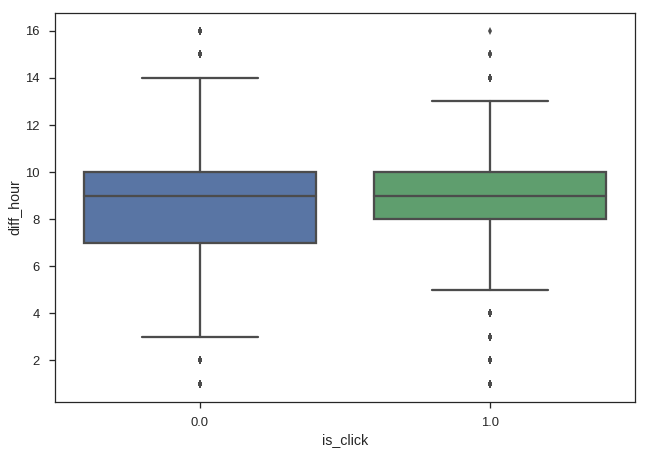

In [110]:
sns.boxplot(x=traintest.loc[traintest.is_click.notnull(), 'is_click'],
            y=traintest.loc[traintest.is_click.notnull(), 'diff_hour']
           );

### Mean difference between consecutive mailer sent

In [6]:
def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1
    
avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)

user_id
5         35.833333
6         26.444444
7         13.705882
8         17.357143
9         24.100000
11        13.500000
12        27.750000
13        35.333333
14        -1.000000
15        20.166667
16        -1.000000
17        31.000000
18        46.250000
19        23.400000
21        33.833333
22         5.000000
23        21.727273
24        22.000000
25        18.538462
26        -1.000000
27        24.100000
28         5.000000
29        25.000000
30        30.250000
31        30.625000
32        55.666667
34        10.000000
35        12.150000
36        -1.000000
37         9.600000
            ...    
240956    32.000000
240957    11.200000
240958    19.666667
240959    22.750000
240960    21.727273
240961    23.222222
240962    28.285714
240963    17.416667
240964    16.785714
240965    27.111111
240966    18.000000
240967    24.300000
240968    26.333333
240971    28.000000
240972    22.000000
240973    18.461538
240974    13.333333
240975    27.714286
240976    32

In [9]:
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

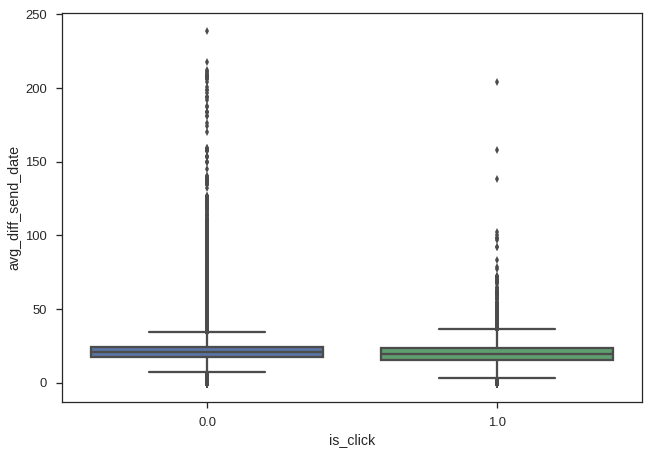

In [10]:
sns.boxplot(x=traintest.loc[traintest.is_click.notnull(), 'is_click'],
            y=traintest.loc[traintest.is_click.notnull(), 'avg_diff_send_date']
           );

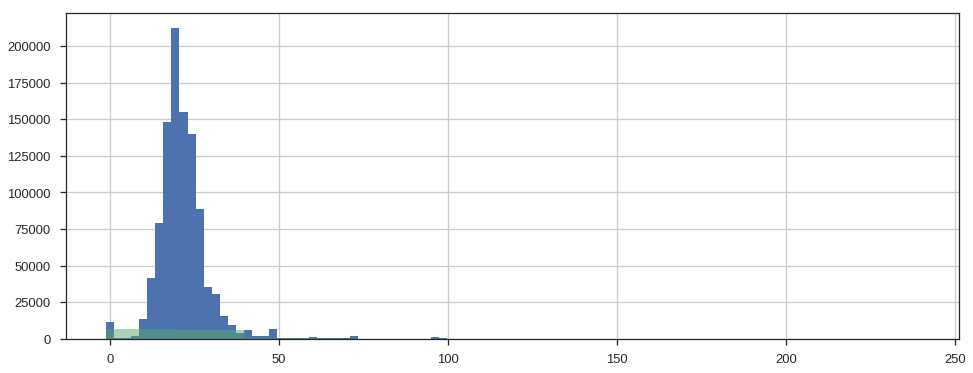

In [21]:
plt.figure(figsize=(16, 6))
traintest.loc[(traintest.is_click.notnull()) & (traintest.is_click == 0), 'avg_diff_send_date'].hist(bins=100)
traintest.loc[(traintest.is_click.notnull()) & (traintest.is_click == 1), 'avg_diff_send_date'].hist(alpha=.5);

In [18]:
ss = pd.crosstab(pd.cut(traintest.loc[traintest.is_click.notnull()].avg_diff_send_date, bins=5, labels=np.arange(0, 5)),
                 traintest.loc[traintest.is_click.notnull()].is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.0025485634904270746


** Age of an user ( date on which last received an email - date on which received an email for first time ) **

In [17]:
%%time

user_age = train_info.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
train_info.loc[:, 'user_age'] = train_info.user_id.map(user_age)

CPU times: user 42.4 s, sys: 734 ms, total: 43.2 s
Wall time: 42.3 s


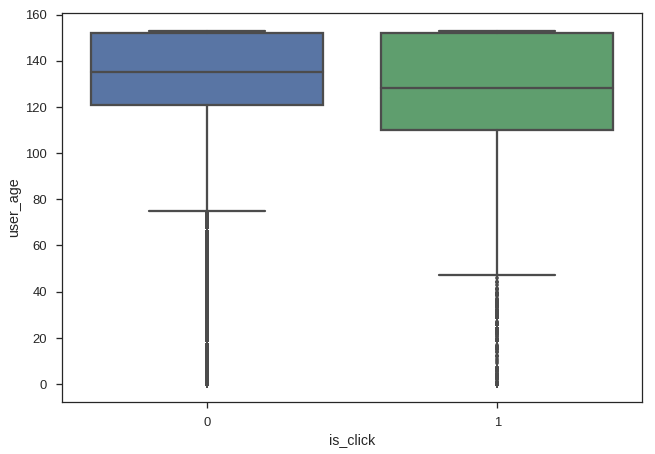

In [19]:
sns.boxplot(x=train_info.loc[:, 'is_click'],
            y=train_info.loc[:, 'user_age']
           );

In [21]:
ss = pd.crosstab(pd.cut(train_info.user_age, bins=10, labels=np.arange(0, 10)), train_info.is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.03060624275557923


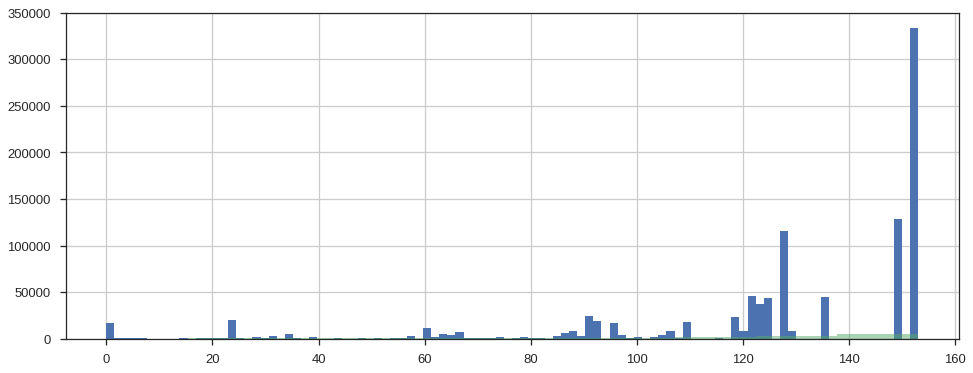

In [24]:
plt.figure(figsize=(16, 6))

train_info.loc[(train_info.is_click == 0), 'user_age'].hist(bins=100)
train_info.loc[(train_info.is_click == 1), 'user_age'].hist(alpha=.5);

### Text Based Features

In [36]:
%%time

# digits
digit_pattern = re.compile(r'\d+')
num_digits_subject = train_info.subject.map(lambda x: len(re.findall(digit_pattern, x)))

CPU times: user 3.91 s, sys: 3.84 ms, total: 3.91 s
Wall time: 3.92 s


In [40]:
ss = pd.crosstab(num_digits_subject, train_info.is_click)

ss.loc[:, 0] = ss.loc[:, 0] / ss.sum(axis=0).iloc[0]
ss.loc[:, 1] = ss.loc[:, 1] / ss.sum(axis=0).iloc[1]
print('Most sent type, Information Value: ', ((ss.loc[:, 0] - ss.loc[:, 1]) * ss.apply(lambda x: np.log(x[0] / x[1]), axis=1)).sum())

Most sent type, Information Value:  0.016333435028718948


In [38]:
train_info.groupby(num_digits_subject)['is_click'].mean()

subject
0    0.013421
1    0.011802
2    0.011839
3    0.043792
Name: is_click, dtype: float64

In [44]:
%%time

# subject has any punctuation
punctuation_pattern = re.compile(r'[!.?\-",]+')
has_punctuation = train_info.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

CPU times: user 3.9 s, sys: 11.8 ms, total: 3.92 s
Wall time: 3.91 s


In [45]:
train_info.groupby(has_punctuation)['is_click'].mean()

subject
0    0.017665
1    0.011469
Name: is_click, dtype: float64

In [6]:
%%time

# number of keywords in subject
num_keywords_in_subject = train_info.subject.map(lambda x: len(x.split(' ')))

CPU times: user 1.1 s, sys: 27 ms, total: 1.13 s
Wall time: 1.17 s


In [9]:
train_info.groupby(num_keywords_in_subject)['is_click'].size()

subject
7      98064
8         67
10    156523
11    142470
12    230197
13    143039
14      3882
15     81358
16     82160
17     85431
Name: is_click, dtype: int64

In [8]:
train_info.groupby(num_keywords_in_subject)['is_click'].mean()

subject
7     0.011666
8     0.029851
10    0.012554
11    0.015119
12    0.013871
13    0.007606
14    0.043792
15    0.012758
16    0.014192
17    0.010090
Name: is_click, dtype: float64

In [11]:
%%time

# number of short keywords
num_short_keywords_in_subject = train_info.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

CPU times: user 4.09 s, sys: 4.32 ms, total: 4.09 s
Wall time: 4.1 s


In [14]:
train_info.groupby(num_short_keywords_in_subject)['is_click'].size()

subject
4      20229
5     220950
6     378304
7      69624
8     167591
9      85135
10     81358
Name: is_click, dtype: int64

In [15]:
train_info.groupby(num_short_keywords_in_subject)['is_click'].mean()

subject
4     0.038509
5     0.013913
6     0.010344
7     0.010600
8     0.012101
9     0.014236
10    0.012758
Name: is_click, dtype: float64

In [18]:
# ratio of short keywords to total keywords in subject
train_info.groupby((num_short_keywords_in_subject / num_keywords_in_subject))['is_click'].size()

subject
0.333333      8809
0.363636      7232
0.416667     90534
0.454545    130416
0.461538     73415
0.470588     85431
0.500000    131828
0.538462     69624
0.545455      4822
0.571429      4121
0.600000    156523
0.642857      3882
0.666667     81358
0.750000     81253
0.857143     93943
Name: is_click, dtype: int64

In [17]:
train_info.groupby((num_short_keywords_in_subject / num_keywords_in_subject))['is_click'].mean()

subject
0.333333    0.061414
0.363636    0.007605
0.416667    0.011410
0.454545    0.015650
0.461538    0.004767
0.470588    0.010090
0.500000    0.013237
0.538462    0.010600
0.545455    0.012028
0.571429    0.043921
0.600000    0.012554
0.642857    0.043792
0.666667    0.012758
0.750000    0.012824
0.857143    0.010251
Name: is_click, dtype: float64

In [19]:
%%time

# number of characters
num_char = train_info.subject.map(lambda x: len(x))

CPU times: user 417 ms, sys: 12.2 ms, total: 429 ms
Wall time: 429 ms


In [21]:
train_info.groupby(num_char)['is_click'].size()

subject
39       4121
53      93943
55      76428
57      51456
59       7559
63       5322
65      97009
71      94834
72      73415
73      39498
75      73112
76       2786
77      69624
84       3882
88      81253
106    166789
111     82160
Name: is_click, dtype: int64

In [22]:
train_info.groupby(num_char)['is_click'].mean()

subject
39     0.043921
53     0.010251
55     0.015714
57     0.012166
59     0.006482
63     0.071402
65     0.015122
71     0.014014
72     0.004767
73     0.011697
75     0.009807
76     0.014716
77     0.010600
84     0.043792
88     0.012824
106    0.011392
111    0.014192
Name: is_click, dtype: float64

In [30]:
%%time

# first keyword of subject
first_keyword = train_info.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0]))

CPU times: user 2.52 s, sys: 40 ms, total: 2.56 s
Wall time: 2.56 s


In [31]:
train_info.groupby(first_keyword)['is_click'].size()

subject
AI              69624
AV              73112
Click            5322
Data             3882
Delhi           46815
Dr              73415
Early            7232
Innovate           67
July            69756
Last            10751
New             17717
Newsletter      82160
November        93943
October         91166
Participate      2786
Register       166789
September      120751
Sneak           69129
Starts           9831
Visualizing      4822
Watch            4121
Name: is_click, dtype: int64

In [32]:
train_info.groupby(first_keyword)['is_click'].mean()

subject
AI             0.010600
AV             0.009807
Click          0.071402
Data           0.043792
Delhi          0.011449
Dr             0.004767
Early          0.007605
Innovate       0.029851
July           0.012615
Last           0.011813
New            0.022521
Newsletter     0.014192
November       0.010251
October        0.013163
Participate    0.014716
Register       0.011392
September      0.012455
Sneak          0.016549
Starts         0.027566
Visualizing    0.012028
Watch          0.043921
Name: is_click, dtype: float64

## Text Modelling

In [23]:
%%time

trn = pd.read_feather('../data/processed/val/ctypev7/tr.feather')
val = pd.read_feather('../data/processed/val/ctypev7/val.feather')

trn = trn.loc[:, ['id', 'email_body', 'is_open', 'is_click']]
val = val.loc[:, ['id', 'email_body', 'is_open', 'is_click']]

CPU times: user 1.55 s, sys: 1.47 s, total: 3.01 s
Wall time: 15.4 s


### Length of Email Body

In [14]:
%%time

# length of email body
email_body_len = trn.email_body.map(lambda x: len(list(filter(lambda x: len(x) > 3, x.split()))))

CPU times: user 38.6 s, sys: 0 ns, total: 38.6 s
Wall time: 38.6 s


In [15]:
trn.groupby(email_body_len)['is_click'].sum()

email_body
22      880
25      181
57      738
70      862
79      651
88       55
89      536
98     1166
109      78
112    1087
113     219
127     350
140      36
142     626
144    1042
154     955
157    1144
Name: is_click, dtype: int64

In [16]:
%%time

# length of email body in validation set
email_body_len = val.email_body.map(lambda x: len(list(filter(lambda x: len(x) > 3, x.split()))))

CPU times: user 6.16 s, sys: 0 ns, total: 6.16 s
Wall time: 6.17 s


In [17]:
val.groupby(email_body_len)['is_click'].sum()

email_body
22     170
30     462
140      5
145    963
207      2
Name: is_click, dtype: int64

### Number of digits in email

In [20]:
digit_pattern             = re.compile(r'\d+')

email_body_num_digits_trn = trn.email_body.map(lambda x: len(re.findall(digit_pattern, x)))
email_body_num_digits_val = val.email_body.map(lambda x: len(re.findall(digit_pattern, x)))

In [21]:
trn.groupby(email_body_num_digits_trn)['is_click'].mean()

email_body
0     0.014362
1     0.012322
2     0.013564
3     0.009807
5     0.014192
6     0.009060
8     0.007031
9     0.014948
10    0.010090
13    0.042962
56    0.016725
Name: is_click, dtype: float64

In [22]:
val.groupby(email_body_num_digits_val)['is_click'].mean()

email_body
0    0.011697
1    0.043792
5    0.029851
7    0.010251
9    0.007728
Name: is_click, dtype: float64

In [28]:
trn.groupby(_)['is_click'].mean()

email_body
False    0.012776
True     0.011544
Name: is_click, dtype: float64

In [30]:
val.groupby(_)['is_click'].mean()

email_body
False    0.011597
True     0.029851
Name: is_click, dtype: float64

### Whether keyword today is in email body

In [29]:
val.email_body.map(lambda x: 'today' in x.lower())

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
138007    False
138008    False
138009    False
138010    False
138011    False
138012    False
138013    False
138014    False
138015    False
138016    False
138017    False
138018    False
138019    False
138020    False
138021    False
138022    False
138023    False
138024    False
138025    False
138026    False
138027    False
138028    False
138029    False
138030    False
138031    False
138032    False
138033    False
138034    False
138035    False
138036    False
Name: email_body, Length

### Whether upcoming in email body or not

In [47]:
%%time

hurry_in_body     = trn.email_body.map(lambda x: 'upcoming' in re.sub(r'!,', '', x.lower()))
hurry_in_body_val = val.email_body.map(lambda x: 'upcoming' in re.sub(r'!,', '', x.lower())) 

CPU times: user 6.29 s, sys: 7.99 ms, total: 6.29 s
Wall time: 6.29 s


### Go through body of positive class instances

In [53]:
val.loc[val.is_click == 1, 'email_body'].iloc[0]

'Upcoming Hackathons\r\n[Machine Learning]  \r\n \r\nDear AVian,\r\n\r\nWe are announcing new data science hackathons for you to participate in the next 15 days. Schedule your calendar and get ready to prove your machine learning expertise.\r\n'

In [54]:
val.loc[val.is_click == 1, 'email_body'].iloc[1]

'[September Events]\r\n \r\nDear AVians,\r\n \r\nAre your eager to know what are the upcoming challenges & meetups for you this September? Read on, to know about exciting events & competitions coming up.Get ready for some cash prizes and ultimate learning with our upcoming events. '

In [55]:
val.loc[val.is_click == 1, 'email_body'].iloc[2]

'[September Events]\r\n \r\nDear AVians,\r\n \r\nAre your eager to know what are the upcoming challenges & meetups for you this September? Read on, to know about exciting events & competitions coming up.Get ready for some cash prizes and ultimate learning with our upcoming events. '

In [56]:
val.loc[val.is_click == 1, 'email_body'].iloc[3]

'[September Events]\r\n \r\nDear AVians,\r\n \r\nAre your eager to know what are the upcoming challenges & meetups for you this September? Read on, to know about exciting events & competitions coming up.Get ready for some cash prizes and ultimate learning with our upcoming events. '

In [57]:
val.loc[val.is_click == 1, 'email_body'].iloc[4]

'December Newsletter\r\n \r\nDear AVians,\r\n \r\nA BIG \x93Thank You\x94 to all of you - DataHack Summit 2017 was a huge success. We got 800 data science professionals including industry thought leaders at the venue. The feedback and the enthusiasm for the Summit was unparalleled to any other event I have ever seen.\r\n\r\nWith this awesome feedback from community and incessant demand / requests from Mumbai and Pune - we decided to do DataFest 2018, Mumbai. The occasion will also mark 5 year Anniversary for Analytics Vidhya - we are already getting excited for this. For more details, please subscribe to the updates for DataFest 2018, Mumbai. We will share more details with you shortly.\r\n\r\nNovember also saw 3 very exciting hackathons - McKinsey Online Analytics Hackathon, Cross Sell: target the right customer and Churn Prediction. We have a series of hackathons coming up all the way through new year, so see you all competing for these exciting challenges. We also continued to publi